### Illustration

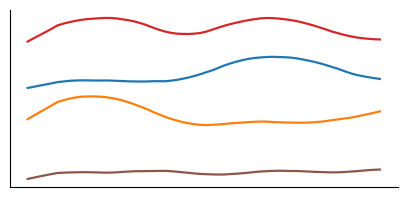

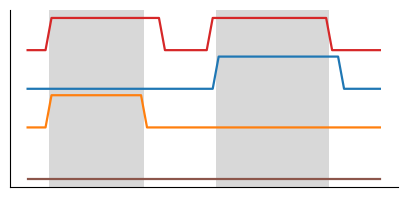

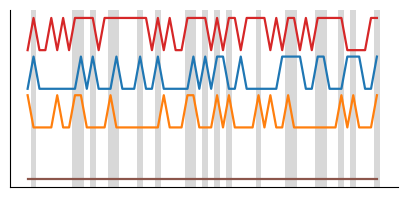

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------ 用户给定的模拟与颜色 ------------------
np.random.seed(0)
n_time = 130
n_emotions = 6
threshold = 0.5
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

# 真实的0/1矩阵（来自你的示例）
real_data = np.zeros((n_time, 6))
real_data[np.concatenate((np.arange(20), np.arange(30,50), np.arange(80,83))).astype(int),0] = 1
real_data[np.arange(31,52).astype(int),1] = 1
real_data[np.concatenate((np.arange(20), np.arange(62,83), np.arange(100,104))).astype(int),2] = 1
real_data[np.concatenate((np.arange(45,48), np.arange(95,120))).astype(int),3] = 1
real_data[np.arange(64,84).astype(int),4] = 1
real_data[np.arange(96,120).astype(int),5] = 1

# ------------------ 生成“六维情绪曲线” ------------------
# 根据 real_data 的 0/1：0 -> [0,3.5]；1 -> [3.5,7]，再用滑窗平滑
rng = np.random.default_rng(42)
raw_curves = np.zeros_like(real_data, dtype=float)
low_lo, low_hi = 0.0, 3.5
hi_lo,  hi_hi  = 3.5, 7.0

for d in range(n_emotions):
    vals = np.empty(n_time, dtype=float)
    mask_hi = real_data[:, d] > 0.5
    vals[~mask_hi] = rng.uniform(low_lo, low_hi, size=(~mask_hi).sum())
    vals[mask_hi]  = rng.uniform(hi_lo,  hi_hi,  size=mask_hi.sum())
    raw_curves[:, d] = vals

# 平滑（滑动窗口：5 或 10，这里用 10）
def moving_avg(x, w):
    if w <= 1:
        return x
    c = np.convolve(x, np.ones(w)/w, mode='same')
    # two-pass轻微平滑边缘
    return np.convolve(c, np.ones(w)/w, mode='same')

n_time = 60
threshold = 3.5
window = 10
smoothed_curves = np.vstack([moving_avg(raw_curves[:, d], window) for d in range(n_emotions)]).T
smoothed_curves = smoothed_curves[:60, :]

# 打乱（逐维随机置乱时间）
shuffled_data = np.zeros_like(smoothed_curves)
for i in range(6):
    shuffled_data[:, i] = smoothed_curves[np.random.permutation(60), i]

# 阈值化
real_bin = (smoothed_curves > threshold).astype(int)
shuf_bin = (shuffled_data > threshold).astype(int)

real_multi = (real_bin.sum(axis=1) >= 2).astype(int)
shuf_multi = (shuf_bin.sum(axis=1) >= 2).astype(int)

prop_real = real_multi.mean()
prop_shuf = shuf_multi.mean()

# ------------------ 作图：上-曲线，中-真实二值化+红色标注，下-shuffle ------------------
fig = plt.figure(figsize=(5, 2.3))
gs = fig.add_gridspec(1, 1)

# (1) 六维曲线
ax0 = fig.add_subplot(gs[0, 0])
t = np.arange(n_time)
for d in range(3):
    ax0.plot(t, smoothed_curves[:, d]+20-6*d, lw=1.6, color=EMO_COLORS[d])
ax0.plot(t, smoothed_curves[:, 5], lw=1.6, color=EMO_COLORS[5])
# 只画曲线，不要坐标轴/数字
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.set_xticks([]); ax0.set_yticks([])
plt.savefig('figures/coocurrence_illus1.svg', dpi=300, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(5, 2.3))
gs = fig.add_gridspec(1, 1)
# (2) 真实二值化
ax1 = fig.add_subplot(gs[0, 0])
t = np.arange(n_time)
for d in range(3):
    ax1.plot(t, real_bin[:, d]+4-1.2*d, lw=1.6, color=EMO_COLORS[d])
ax1.plot(t, real_bin[:, 5], lw=1.6, color=EMO_COLORS[5])
# 只画曲线，不要坐标轴/数字
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks([]); ax1.set_yticks([])
# ax1.imshow(real_bin.T, aspect='auto', cmap='Greys', interpolation='nearest')
# ax1.set_yticks([]); ax1.set_xticks([])
# ax1.set_title(f"Real (≥2 active proportion = {prop_real:.2f})", fontsize=12)
for t_idx in np.where(real_multi == 1)[0]:
    ax1.axvspan(t_idx - 0.5, t_idx + 0.5, color='gray', alpha=0.3, edgecolor=None, linewidth=0)
plt.savefig('figures/coocurrence_illus2.svg', dpi=300, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(5, 2.3))
gs = fig.add_gridspec(1, 1)
# (3) Shuffle 二值化
ax2 = fig.add_subplot(gs[0, 0])
t = np.arange(n_time)
for d in range(3):
    ax2.plot(t, shuf_bin[:, d]+4-1.2*d, lw=1.6, color=EMO_COLORS[d])
ax2.plot(t, shuf_bin[:, 5], lw=1.6, color=EMO_COLORS[5])
# 只画曲线，不要坐标轴/数字
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([]); ax2.set_yticks([])

# ax2.imshow(shuf_bin.T, aspect='auto', cmap='Greys', interpolation='nearest')
# ax2.set_yticks([]); ax2.set_xticks([])
# ax2.set_title(f"Shuffled (≥2 active proportion = {prop_shuf:.2f})", fontsize=12)
for t_idx in np.where(shuf_multi == 1)[0]:
    ax2.axvspan(t_idx - 0.5, t_idx + 0.5, color='gray', alpha=0.3, edgecolor=None, linewidth=0)

plt.savefig('figures/coocurrence_illus3.svg', dpi=300, bbox_inches='tight')
plt.show()


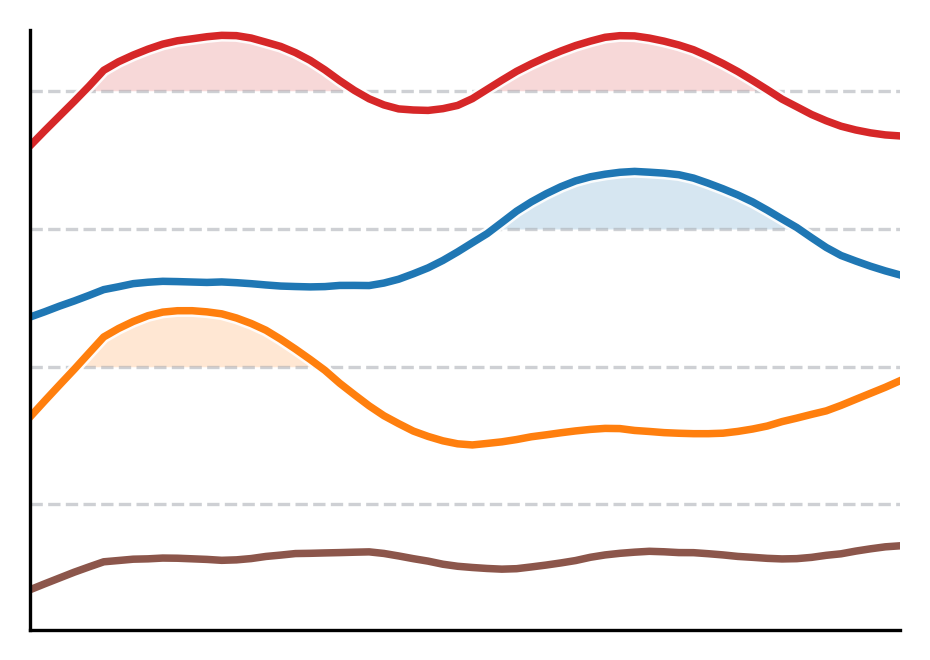

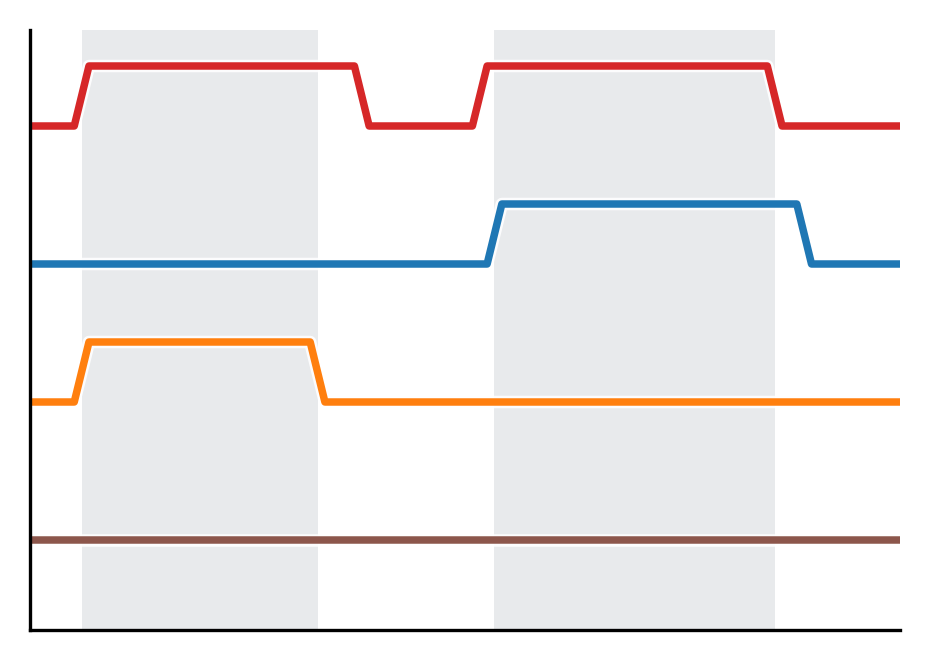

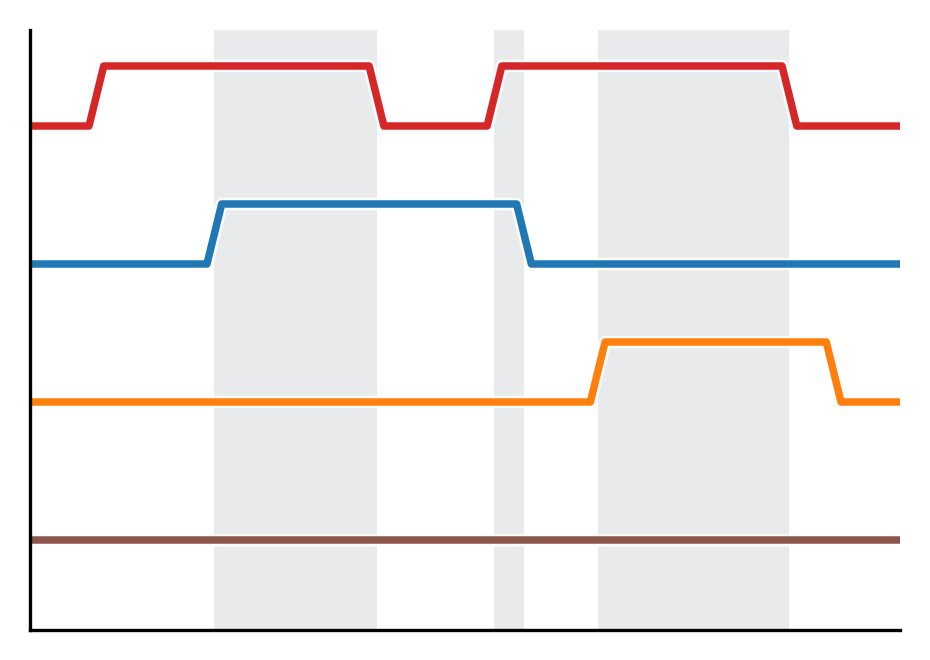

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# ------------------ 用户给定的模拟与颜色 ------------------
np.random.seed(0)
n_time = 130
n_emotions = 6
threshold = 0.5
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

# 真实的0/1矩阵（来自你的示例）
real_data = np.zeros((n_time, 6))
real_data[np.concatenate((np.arange(20), np.arange(30,50), np.arange(80,83))).astype(int),0] = 1
real_data[np.arange(31,52).astype(int),1] = 1
real_data[np.concatenate((np.arange(20), np.arange(62,83), np.arange(100,104))).astype(int),2] = 1
real_data[np.concatenate((np.arange(45,48), np.arange(95,120))).astype(int),3] = 1
real_data[np.arange(64,84).astype(int),4] = 1
real_data[np.arange(96,120).astype(int),5] = 1

# ------------------ 生成“六维情绪曲线” ------------------
rng = np.random.default_rng(42)
raw_curves = np.zeros_like(real_data, dtype=float)
low_lo, low_hi = 0.0, 3.5
hi_lo,  hi_hi  = 3.5, 7.0

for d in range(n_emotions):
    vals = np.empty(n_time, dtype=float)
    mask_hi = real_data[:, d] > 0.5
    vals[~mask_hi] = rng.uniform(low_lo, low_hi, size=(~mask_hi).sum())
    vals[mask_hi]  = rng.uniform(hi_lo,  hi_hi,  size=mask_hi.sum())
    raw_curves[:, d] = vals

def moving_avg(x, w):
    if w <= 1: return x
    c = np.convolve(x, np.ones(w)/w, mode='same')
    return np.convolve(c, np.ones(w)/w, mode='same')

n_time = 60
threshold = 3.5
window = 10
smoothed_curves = np.vstack([moving_avg(raw_curves[:, d], window) for d in range(n_emotions)]).T
smoothed_curves = smoothed_curves[:60, :]

# ------------------ 代理：循环时移（替代随机置乱） ------------------
rng = np.random.default_rng(123)
shifted_data = np.zeros_like(smoothed_curves)
shifts = np.zeros(n_emotions, dtype=int)  # 新增：记录每个维度的位移
for i in range(6):
    s = int(rng.integers(1, n_time))  # 避免 0 位移
    shifts[i] = s 
    shifted_data[:, i] = np.roll(smoothed_curves[:, i], s, axis=0)

# 阈值化
real_bin = (smoothed_curves > threshold).astype(int)
shuf_bin = (shifted_data > threshold).astype(int)

real_multi = (real_bin.sum(axis=1) >= 2).astype(int)
shuf_multi = (shuf_bin.sum(axis=1) >= 2).astype(int)

prop_real = real_multi.mean()
prop_shuf = shuf_multi.mean()

# —— 一致的线型封装：彩色主线 + 白色描边（更“立体”）——
def nice_line(ax, x, y, color, lw=1.8):
    ax.plot(x, y, color=color, lw=lw,
            path_effects=[pe.Stroke(linewidth=lw+1.2, foreground="white", alpha=0.9),
                          pe.Normal()])

# ================== 作图 ==================
PLOT_IDXS = [0, 1, 2, 5]  # 为简洁仅画四条；如需六条用 range(6)
t = np.arange(n_time)

# (1) 连续曲线 + 阈值以上阴影
fig = plt.figure(figsize=(3.2, 2.3), dpi=300)
ax0 = fig.add_subplot(111)
offset = 4.5

for j, d in enumerate(PLOT_IDXS):
    # 假设 t = np.arange(n_time)
    thr_val = threshold + offset*(len(PLOT_IDXS)-1-j)
    thr_arr = np.full_like(t, thr_val, dtype=float)
    y = smoothed_curves[:, d] + offset*(len(PLOT_IDXS)-1-j)
    # 先画填充（zorder 更低，且无边框）
    ax0.fill_between(
        t, thr_arr, y,
        where=(y >= thr_arr),
        color=EMO_COLORS[d], alpha=0.18, linewidth=0,
        interpolate=True, zorder=0
    )

    # 再画阈值虚线（在上层）
    ax0.plot(t, thr_arr, ls="--", lw=0.8, color="#A7AAB1", alpha=0.55, zorder=1.5)

    # 最后画主线（白描边+彩色线，放最上层）
    ax0.plot(
        t, y, color=EMO_COLORS[d], lw=1.8, zorder=2,
        path_effects=[pe.Stroke(linewidth=3.0, foreground="white", alpha=0.9), pe.Normal()]
    )


ax0.set_xlim(0, n_time-1)
ax0.set_ylim(-0.6, threshold + offset*(len(PLOT_IDXS)-1) + 2.0)
ax0.set_xticks([]); ax0.set_yticks([])
for s in ["top","right"]: ax0.spines[s].set_visible(False)
ax0.yaxis.grid(True, linestyle='-', alpha=0.10)
plt.tight_layout()
plt.savefig('figures/coocurrence_illus1.svg', dpi=300, bbox_inches='tight')
plt.show()

# (2) 真实二值化 + 共现灰影
fig = plt.figure(figsize=(3.2, 2.3), dpi=300)
ax1 = fig.add_subplot(111)
offset_b = 2.3
for j, d in enumerate(PLOT_IDXS):
    y = real_bin[:, d] + offset_b*(len(PLOT_IDXS)-1-j) + 1
    nice_line(ax1, t, y, EMO_COLORS[d], lw=1.8)
# 灰影：≥2 情绪同时激活
for ti in np.where(real_multi==1)[0]:
    ax1.axvspan(ti-0.5, ti+0.5, color="#9AA1AA", alpha=0.22, lw=0)

ax1.set_xlim(0, n_time-1)
ax1.set_ylim(-0.5, offset_b*(len(PLOT_IDXS)-1)+1.6+1)
ax1.set_xticks([]); ax1.set_yticks([])
for s in ["top","right"]: ax1.spines[s].set_visible(False)
ax1.yaxis.grid(True, linestyle='-', alpha=0.10)
plt.tight_layout()
plt.savefig('figures/coocurrence_illus2.svg', dpi=300, bbox_inches='tight')
plt.show()

# (3) 循环时移二值化 + 共现灰影（保持同样样式）
fig = plt.figure(figsize=(3.2, 2.3), dpi=300)
ax2 = fig.add_subplot(111)
offset_c = 2.3
for j, d in enumerate(PLOT_IDXS):
    y = shuf_bin[:, d] + offset_c*(len(PLOT_IDXS)-1-j) + 1
    nice_line(ax2, t, y, EMO_COLORS[d], lw=1.8)
for ti in np.where(shuf_multi==1)[0]:
    ax2.axvspan(ti-0.5, ti+0.5, color="#9AA1AA", alpha=0.22, lw=0)

ax2.set_xlim(0, n_time-1)
ax2.set_ylim(-0.5, offset_c*(len(PLOT_IDXS)-1)+1.6+1)
ax2.set_xticks([]); ax2.set_yticks([])
for s in ["top","right"]: ax2.spines[s].set_visible(False)
ax2.yaxis.grid(True, linestyle='-', alpha=0.10)
plt.tight_layout()
plt.savefig('figures/coocurrence_illus3.svg', dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'shifts' is not defined

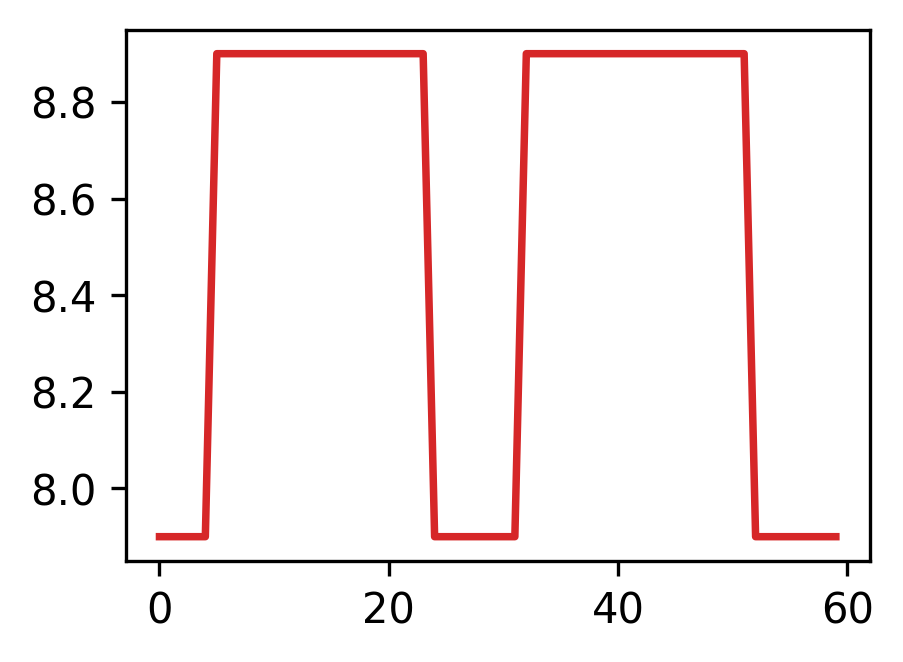

In [4]:
# (3) 循环时移二值化 + 共现灰影（保持同样样式）
fig = plt.figure(figsize=(3.2, 2.3), dpi=300)
ax2 = fig.add_subplot(111)
offset_c = 2.3

width = n_time - 1          # x 轴总长度
arrow_scale = 0.6           # 控制箭头相对长度（0~1 之间，一般 0.4~0.7 比较舒服）

for j, d in enumerate(PLOT_IDXS):
    # 画二值曲线
    y = shuf_bin[:, d] + offset_c*(len(PLOT_IDXS)-1-j) + 1
    nice_line(ax2, t, y, EMO_COLORS[d], lw=1.8)

    # === 在该维度上方画箭头，长度与位移量成比例 ===
    shift = shifts[d]        # 该情绪维度的时移量（单位：time index）
    if shift != 0:
        # 箭头总长度（沿 x 方向），正值向右，负值向左
        dx = arrow_scale * (shift / n_time) * width

        # 让箭头大致居中放在中间位置：
        x0 = (width - dx) / 2.0

        # 箭头的 y 位置：略高于该 emotion 的二值线
        y0 = offset_c*(len(PLOT_IDXS)-1-j) + 2.0

        ax2.arrow(
            x0, y0, dx, 0,
            length_includes_head=True,
            head_width=0.25,
            head_length=2.0,
            linewidth=0.8,
            color=EMO_COLORS[d],
            alpha=0.9,
            zorder=3,
        )

# 灰影：≥2 情绪同时激活
for ti in np.where(shuf_multi==1)[0]:
    ax2.axvspan(ti-0.5, ti+0.5, color="#9AA1AA", alpha=0.22, lw=0)

ax2.set_xlim(0, n_time-1)
ax2.set_ylim(-0.5, offset_c*(len(PLOT_IDXS)-1)+1.6+1)
ax2.set_xticks([]); ax2.set_yticks([])
for s in ["top","right"]: ax2.spines[s].set_visible(False)
ax2.yaxis.grid(True, linestyle='-', alpha=0.10)
plt.tight_layout()
# plt.savefig('figures/coocurrence_illus3.svg', dpi=300, bbox_inches='tight')
plt.show()


### Load data

In [60]:
import pickle

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\scores_allMovies_resample.pkl', 'rb') as f:
    scores_dict = pickle.load(f)
# del scores_dict['BV1zW411d7Rb']
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\times_allMovies_resample.pkl', 'rb') as f:
    time_dict= pickle.load(f)
# del time_dict['BV1zW411d7Rb']

print(len(scores_dict.keys()))
print(len(time_dict.keys()))

scores_all = np.zeros((0,6))
n_samples = []

scores_key = list(scores_dict.keys())
count = 0
for key in scores_key:
    print(scores_dict[key].shape)
    scores_all = np.concatenate((scores_all, scores_dict[key]), 0)
    n_samples.append(scores_dict[key].shape[0])
    count += 1
print(scores_all.shape)
n_samples_cum = np.concatenate((np.array([0]), np.cumsum(n_samples)))
print(n_samples_cum[-5:])

102
102
(4565, 6)
(3699, 6)
(4218, 6)
(1158, 6)
(3955, 6)
(3907, 6)
(4714, 6)
(3192, 6)
(2984, 6)
(3800, 6)
(3051, 6)
(3007, 6)
(4277, 6)
(5197, 6)
(3371, 6)
(3058, 6)
(3692, 6)
(3824, 6)
(3642, 6)
(3513, 6)
(6846, 6)
(2616, 6)
(2717, 6)
(3223, 6)
(3500, 6)
(4148, 6)
(3174, 6)
(3960, 6)
(3516, 6)
(3088, 6)
(4303, 6)
(2692, 6)
(4010, 6)
(2179, 6)
(2700, 6)
(4200, 6)
(3530, 6)
(3611, 6)
(3210, 6)
(4031, 6)
(3293, 6)
(4606, 6)
(5233, 6)
(3487, 6)
(4200, 6)
(3405, 6)
(4484, 6)
(3562, 6)
(3987, 6)
(4766, 6)
(3337, 6)
(2703, 6)
(2995, 6)
(2522, 6)
(4044, 6)
(3547, 6)
(3019, 6)
(2789, 6)
(1396, 6)
(3753, 6)
(3557, 6)
(4445, 6)
(5073, 6)
(3361, 6)
(3299, 6)
(3914, 6)
(2651, 6)
(2634, 6)
(3734, 6)
(3296, 6)
(5312, 6)
(4252, 6)
(2729, 6)
(2721, 6)
(3117, 6)
(2910, 6)
(4223, 6)
(2703, 6)
(3214, 6)
(3854, 6)
(3990, 6)
(3631, 6)
(3372, 6)
(2874, 6)
(3032, 6)
(2207, 6)
(3129, 6)
(2081, 6)
(2788, 6)
(2601, 6)
(4910, 6)
(3071, 6)
(1895, 6)
(4002, 6)
(4031, 6)
(3191, 6)
(2957, 6)
(3355, 6)
(2830, 6)
(3

In [9]:
def circular_shift_surrogate(curves, rng=None, min_shift=1):
    """
    对每个情绪维度独立做循环时移，保留单通道的自相关/谱结构，打破跨通道的瞬时对齐。
    curves: (T, D)
    """
    if rng is None:
        rng = np.random.default_rng()
    T, D = curves.shape
    out = np.empty_like(curves)
    for i in range(D):
        # 在 [min_shift, T-1] 内随机选一个位移（避免 0 位移）
        s = int(rng.integers(min_shift, T))
        out[:, i] = np.roll(curves[:, i], s, axis=0)
    return out

12


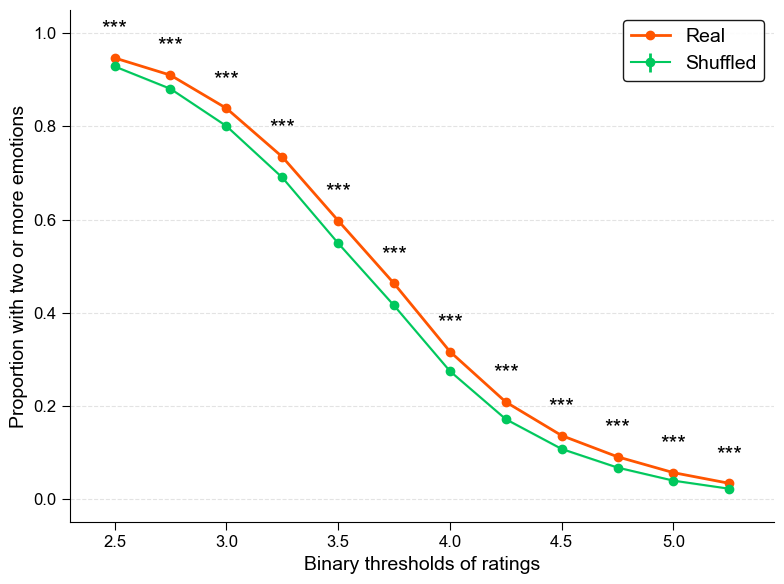

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

X_data = scores_all
tmp = np.arange(2.5,5.5,0.25)
print(len(tmp))
prop_thr = np.zeros((len(tmp), 3))
count = 0
for thr in tmp:
    data_thr = (X_data > thr).astype(int)
    
    prop_thr[count,0] = np.sum(np.sum(data_thr, axis=1) == 0) / data_thr.shape[0]
    prop_thr[count,1] = np.sum(np.sum(data_thr, axis=1) == 1) / data_thr.shape[0]
    prop_thr[count,2] = np.sum(np.sum(data_thr, axis=1) > 1) / data_thr.shape[0]
    count += 1
    
# random shuffle
np.random.seed(0)
prop_thr_shuffle = np.zeros((1000, len(tmp), 3))
for i in range(1000):
    # X_data_shuffle = np.zeros_like(X_data)
    # for j in range(6):
    #     X_data_shuffle[:,j] = X_data[np.random.permutation(X_data.shape[0]),j]
    rng = np.random.default_rng(i)
    X_data_shuffle = circular_shift_surrogate(X_data, rng=rng, min_shift=1)
    count = 0
    for thr in tmp:
        data_thr = (X_data_shuffle > thr).astype(int)
        
        prop_thr_shuffle[i,count,0] = np.sum(np.sum(data_thr, axis=1) == 0) / data_thr.shape[0]
        prop_thr_shuffle[i,count,1] = np.sum(np.sum(data_thr, axis=1) == 1) / data_thr.shape[0]
        prop_thr_shuffle[i,count,2] = np.sum(np.sum(data_thr, axis=1) > 1) / data_thr.shape[0]
        count += 1
        
thresholds = tmp  
num_simulations = 1000 # 随机打乱模拟次数

# 真实数据比例（每个阈值下）
real_proportions = prop_thr[:,2]

# 随机打乱数据比例（每个阈值下的分布）
# 这里使用正态分布模拟，实际应根据您的数据计算
random_distributions = {
    thresholds[i]: prop_thr_shuffle[:,i,2] for i in range(len(thresholds))
}

plt.rcParams['font.family'] = 'Arial'
GREEN = '#00C85D'
RED   = '#FF5500'
BLACK = '#000000'
# colors = [, '#00BFFF', ]

def p_to_stars(p):
    if p < 1e-3: return '***'
    if p < 1e-2: return '**'
    if p < 5e-2: return '*'
    return 'ns'

# ——— 数据准备 ———
thr = np.array(thresholds, dtype=float)
real = np.array(real_proportions, dtype=float)
shuf_mean = np.array([np.mean(random_distributions[t]) for t in thresholds])
shuf_std  = np.array([np.std (random_distributions[t], ddof=1) for t in thresholds])

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(8, 6))

# 1) Shuffled 折线 + 标准差误差棒
ax.errorbar(thr, shuf_mean, yerr=shuf_std,
            fmt='-o', color=GREEN, ecolor=GREEN,
            elinewidth=2.0, capsize=0, ms=6, label='Shuffled')

ax.fill_between(thr, shuf_mean - shuf_std, shuf_mean + shuf_std,
                color=GREEN, alpha=0.15)

# 2) Real 折线（点稍小）
ax.plot(thr, real, '-o', color=RED, lw=2, ms=6, label='Real')

# 3) 显著性星号（单侧：shuffle < real）
for i, t in enumerate(thr):
    surr = np.asarray(random_distributions[t])
    try:
        p = float(stats.ttest_1samp(surr, real[i], alternative='less').pvalue)
    except TypeError:
        tstat, p2 = stats.ttest_1samp(surr, real[i])
        p = p2/2 if surr.mean() < real[i] else 1 - p2/2
    stars = p_to_stars(p)

    y_ref = max(real[i], shuf_mean[i] + shuf_std[i])
    ax.text(t, y_ref + 0.04, stars, ha='center', va='bottom',
            color=BLACK, fontsize=16)

# 轴与网格
ax.set_xlabel('Binary thresholds of ratings', fontsize=14)
ax.set_ylabel('Proportion with two or more emotions', fontsize=14)
# ax.set_xticks(thr)
ax.set_xlim(thr.min() - 0.2, thr.max() + 0.2)
ax.set_ylim(-0.05, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.35)

# 边框与刻度
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='out',
               bottom=True, top=False, left=True, right=False,
               length=6)

ax.legend(frameon=True, framealpha=0.9, edgecolor='black',
          fontsize=14, loc='best')

plt.tight_layout()
# plt.savefig('figures/cooccurrence_curve2.svg', dpi=300, bbox_inches='tight')
plt.show()


In [396]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- 统一配色（与前面一致） ---
COLOR_SHUFFLED = "#8E98A7"   # baseline
COLOR_REAL = "#e377c2"   # 明亮粉紫色（magenta-pink）
EDGE_COLOR     = "#2E3440"
SPINE_COLOR    = "#D1D5DB"

def _p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "n.s."

def plot_real_vs_shuffled(random_distr,
                          real_proportion,
                          xlabel="Proportion (≥2 emotions)",
                          alternative="greater",   # "greater" | "less" | "two-sided"
                          bins=24,
                          show_ci=True,
                          savepath=None,
                          figsize=(3.6, 2.2), dpi=300):
    """
    显示真实取值在循环时移/打乱分布中的位置，并给出经验 p 值。
    alternative:
        - "greater": H1: real > null
        - "less":    H1: real < null
        - "two-sided": 双侧置换检验（相对于中位数的对称尾）
    """
    rd = np.asarray(random_distr, float).ravel()
    real = float(real_proportion)
    n = len(rd)

    # --- 经验 p 值 ---
    p_right = (np.sum(rd >= real) + 1) / (n + 1)
    p_left  = (np.sum(rd <= real) + 1) / (n + 1)
    if alternative == "greater":
        p = p_right
    elif alternative == "less":
        p = p_left
    else:  # two-sided
        p = min(1.0, 2 * min(p_left, p_right))
    stars = _p_to_stars(p)

    # --- x 轴范围与网格 ---
    xmin = min(rd.min(), real)
    xmax = max(rd.max(), real)
    pad  = 0.04 * (xmax - xmin + 1e-12)
    x = np.linspace(xmin - pad, xmax + pad, 512)

    # --- KDE（若无 scipy，则回退为插值直方图） ---
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(rd)
        y = kde(x)
    except Exception:
        hist, edges = np.histogram(rd, bins=bins, range=(xmin - pad, xmax + pad), density=True)
        xc = 0.5 * (edges[1:] + edges[:-1])
        y = np.interp(x, xc, hist)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # 直方图
    ax.hist(rd, bins=bins, color=COLOR_SHUFFLED, edgecolor=EDGE_COLOR, linewidth=0.4,
            alpha=0.55, density=True)

    # KDE 曲线
    ax.plot(x, y, color=COLOR_SHUFFLED, lw=1)

    # 95% 区间（可选）
    # if show_ci:
    #     q2p5, q97p5 = np.quantile(rd, [0.025, 0.975])
    #     ax.axvspan(q2p5, q97p5, color=COLOR_SHUFFLED, alpha=0.10, lw=0)

    # 阴影标出检验的“尾部”区域
    if alternative == "greater":
        ax.fill_between(x, 0, y, where=(x >= real), color=COLOR_SHUFFLED, alpha=0.25, linewidth=0)
        tail_label = "Shifted tail (≥ real)"
    elif alternative == "less":
        ax.fill_between(x, 0, y, where=(x <= real), color=COLOR_SHUFFLED, alpha=0.25, linewidth=0)
        tail_label = "Shifted tail (≤ real)"
    else:  # two-sided：以中位数为中心的对称尾
        m = np.median(rd)
        ax.fill_between(x, 0, y, where=(np.abs(x - m) >= abs(real - m)),
                        color=COLOR_SHUFFLED, alpha=0.25, linewidth=0)
        tail_label = "Two-sided tail"

    # 真实值竖线
    ax.axvline(real, color=COLOR_REAL, lw=2.0, zorder=3)

    # 样式（子刊风）
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    # print(rd.min(), real)
    # ax.set_xlim([rd.min()-0.02, real+0.02])
    # ax.set_xlim([0.52,0.63])
    ax.yaxis.grid(True, linestyle='-', alpha=0.12)
    ax.set_axisbelow(True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.tick_params(labelsize=8)

    # 右上角标注 p 值与星号
    handles = [
        Patch(facecolor=COLOR_SHUFFLED, edgecolor=EDGE_COLOR, alpha=0.35, label="Shifted distribution"),
        Line2D([0], [0], color=COLOR_REAL, lw=2.0, label="Real value"),
    ]
    # 将图注放在上方
    # ax.legend(handles=handles, frameon=False, fontsize=8,
    #           loc="upper center", bbox_to_anchor=(0.5, 1.3), borderaxespad=0.2)

    # 预留上边空白，避免 legend 被裁剪
    plt.tight_layout(rect=(0, 0, 1, 0.9))

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    return fig, ax, p


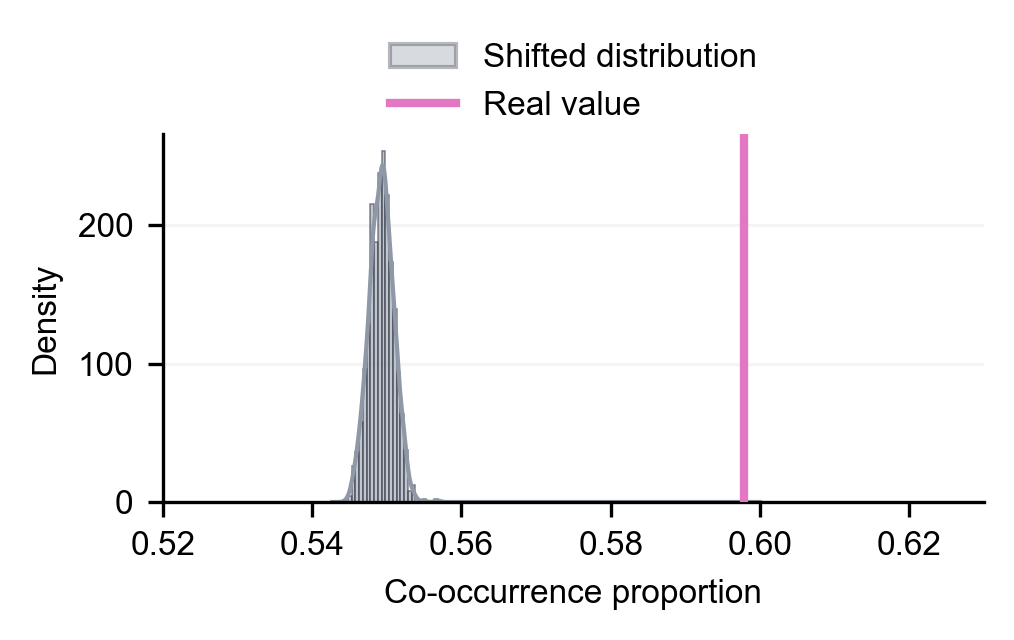

In [388]:
random_distr = random_distributions[3.5]
real_proportion = real_proportions[4]
fig, ax, p = plot_real_vs_shuffled(random_distr, real_proportion,
                                   xlabel="Co-occurrence proportion",
                                   alternative="greater",
                                   savepath="figures/real_vs_shifted_distribution.svg")
plt.show()

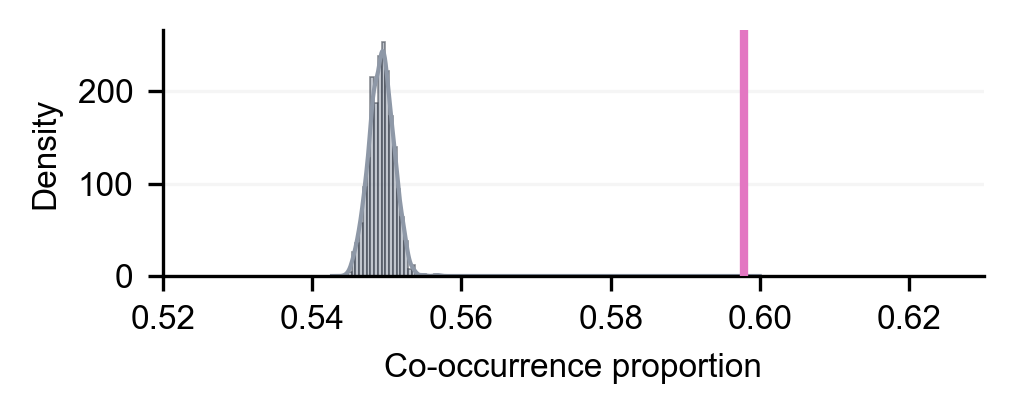

In [390]:
random_distr = random_distributions[3.5]
real_proportion = real_proportions[4]
fig, ax, p = plot_real_vs_shuffled(random_distr, real_proportion, figsize=(3.6, 1.6),
                                   xlabel="Co-occurrence proportion",
                                   alternative="greater",
                                   savepath="figures/real_vs_shifted_distribution.svg")
plt.show()

0.9250578378742615 0.9471092293524405


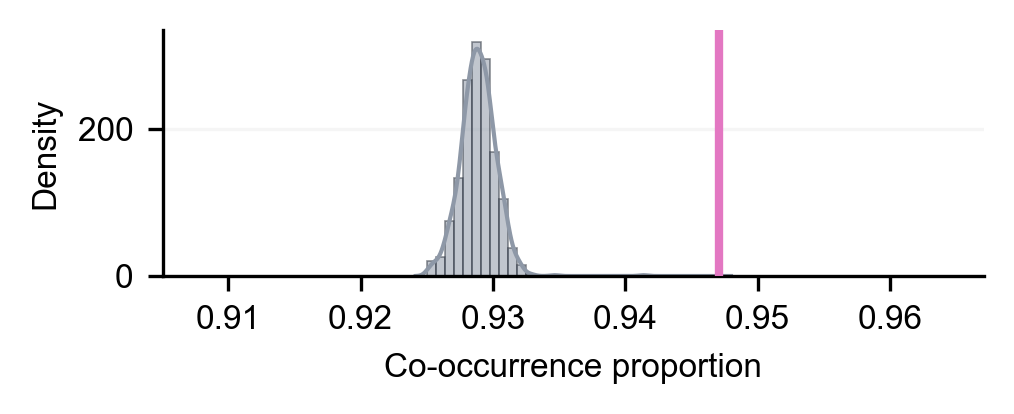

0.8765919453740931 0.9100957974888255


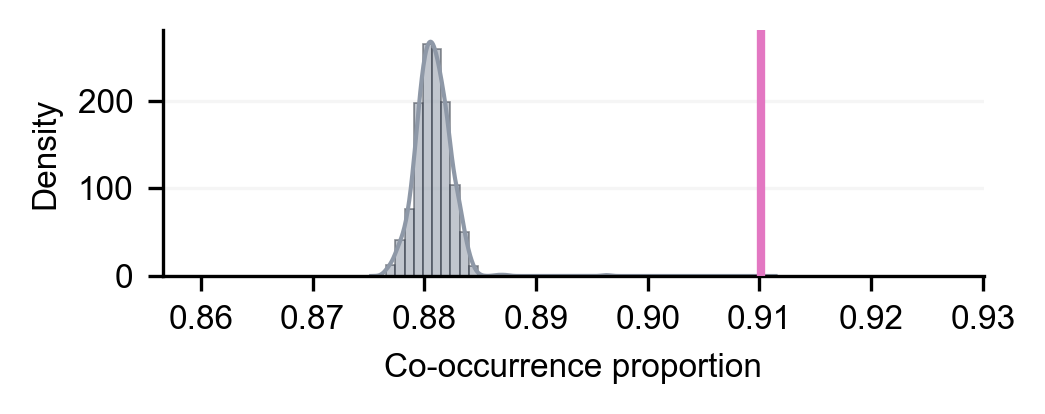

0.7963489139956426 0.8390057500954605


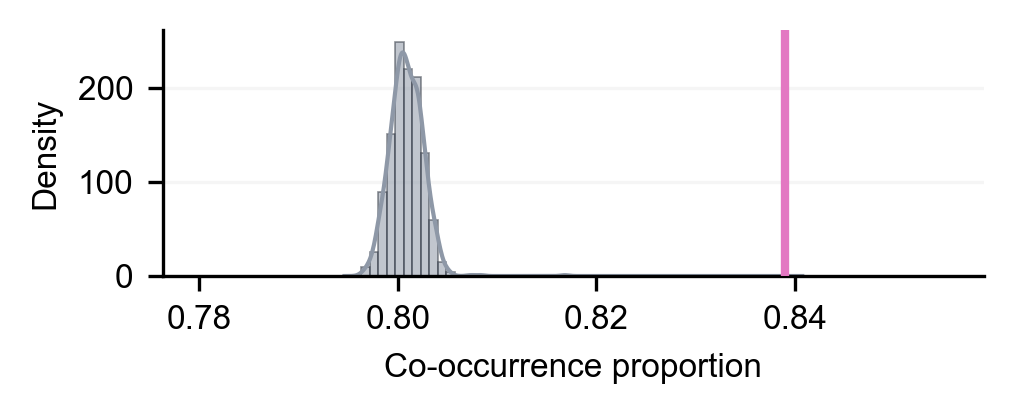

0.6855697311381146 0.7347824622088452


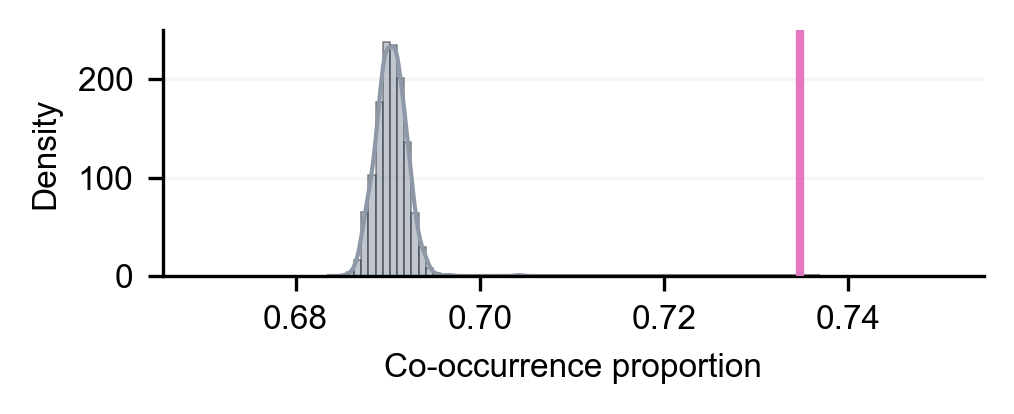

0.544799083578536 0.597835852743649


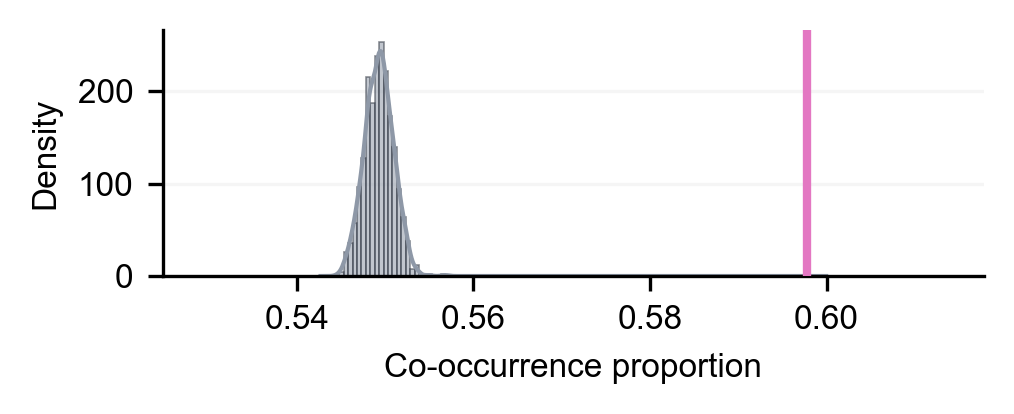

0.4105085240672941 0.46284618494642976


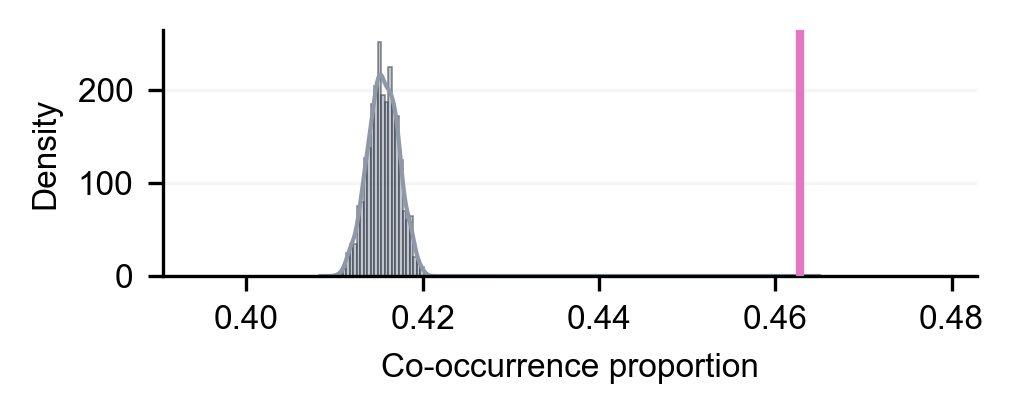

0.2692381123514746 0.3166595539183756


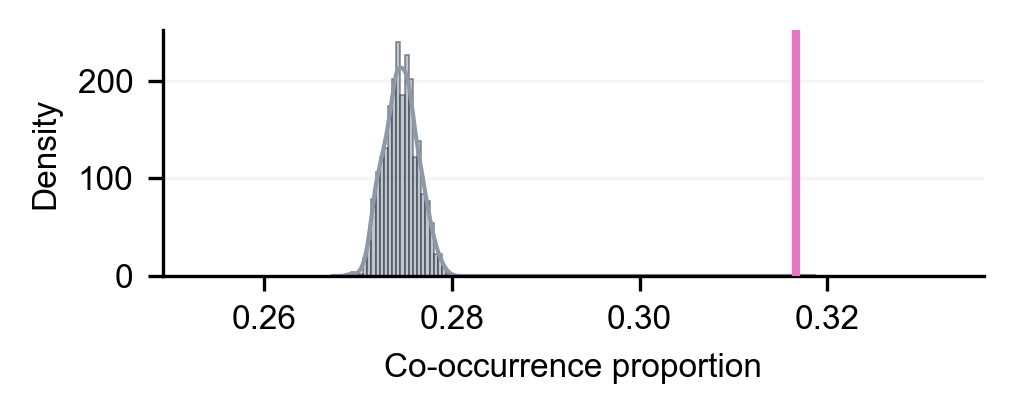

0.16596100716515802 0.2082640776262887


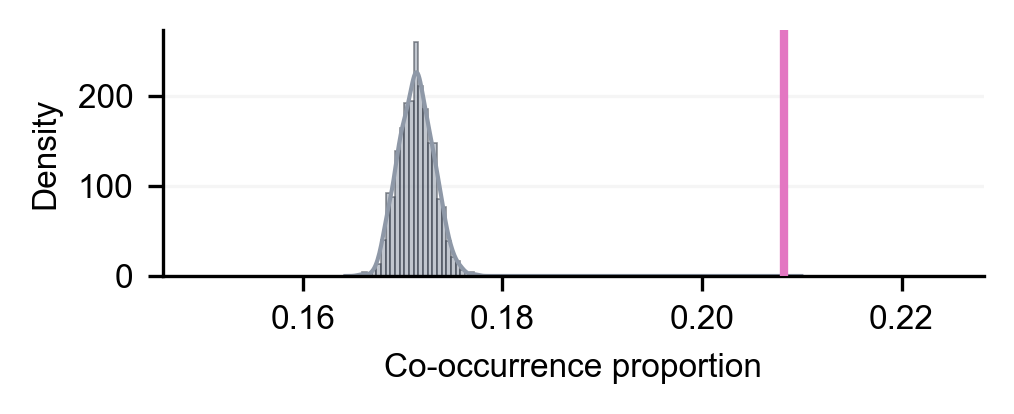

0.10244042137418297 0.13615204061004918


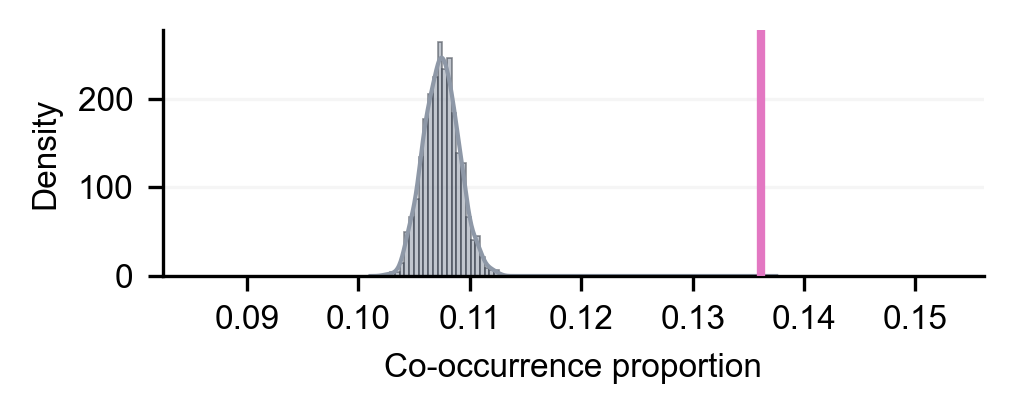

0.06330720334224299 0.09056119584016531


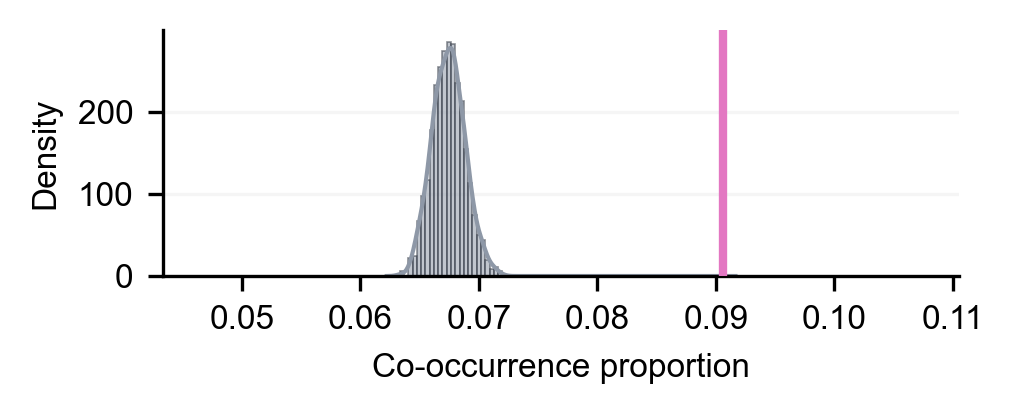

0.03583140540419128 0.0565266952674019


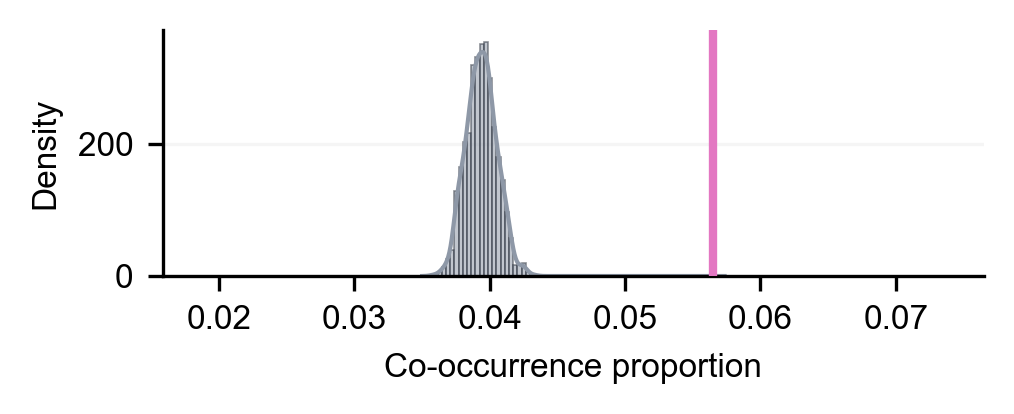

0.019572224343568204 0.033599312683901976


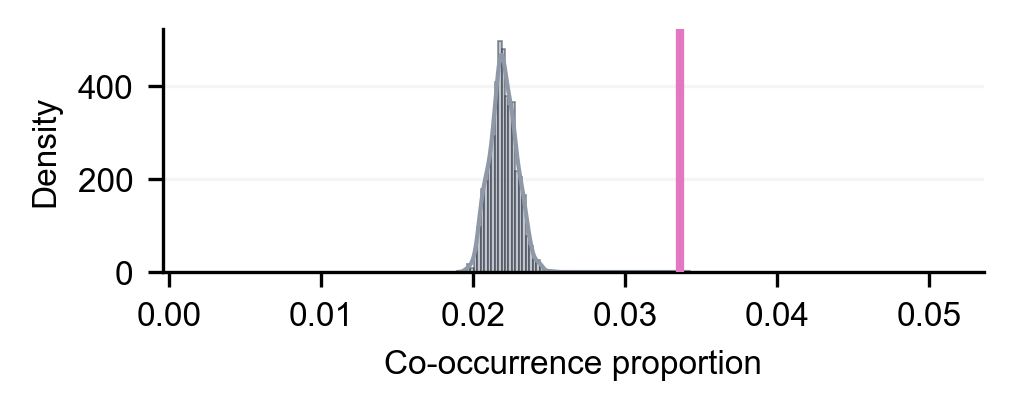

In [384]:
for count, thr in enumerate(list(random_distributions.keys())):
    random_distr = random_distributions[thr]
    real_proportion = real_proportions[count]
    fig, ax, p = plot_real_vs_shuffled(random_distr, real_proportion, figsize=(3.6, 1.6),
                                    xlabel="Co-occurrence proportion",
                                    alternative="greater",
                                    savepath="figures/real_vs_shifted_distribution_thr%.2f.svg" % thr)
    plt.show()

In [391]:
# Different number of emotions
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

X_data = scores_all
tmp = np.arange(2.5,5.5,0.25)
print(len(tmp))
prop_thr = np.zeros((len(tmp), 7))
count = 0
for thr in tmp:
    data_thr = (X_data > thr).astype(int)
    
    for j  in range(7):
        prop_thr[count,j] = np.sum(np.sum(data_thr, axis=1) == j) / data_thr.shape[0]
    count += 1
    
# random shuffle
np.random.seed(0)
prop_thr_shuffle = np.zeros((1000, len(tmp), 7))
for i in range(1000):
    # X_data_shuffle = np.zeros_like(X_data)
    # for j in range(6):
    #     X_data_shuffle[:,j] = X_data[np.random.permutation(X_data.shape[0]),j]
    rng = np.random.default_rng(i)
    X_data_shuffle = circular_shift_surrogate(X_data, rng=rng, min_shift=1)
    count = 0
    for thr in tmp:
        data_thr = (X_data_shuffle > thr).astype(int)
        
        for j in range(7):
            prop_thr_shuffle[i,count,j] = np.sum(np.sum(data_thr, axis=1) == j) / data_thr.shape[0]
        count += 1
        
thresholds = tmp  
num_simulations = 1000 # 随机打乱模拟次数

# 真实数据比例（每个阈值下）
# real_proportions = prop_thr[:,2]

# 随机打乱数据比例（每个阈值下的分布）
# 这里使用正态分布模拟，实际应根据您的数据计算
# random_distributions = {
#     thresholds[i]: prop_thr_shuffle[:,i,2] for i in range(len(thresholds))
# }

12


In [392]:
print(tmp[4])

3.5


2.5


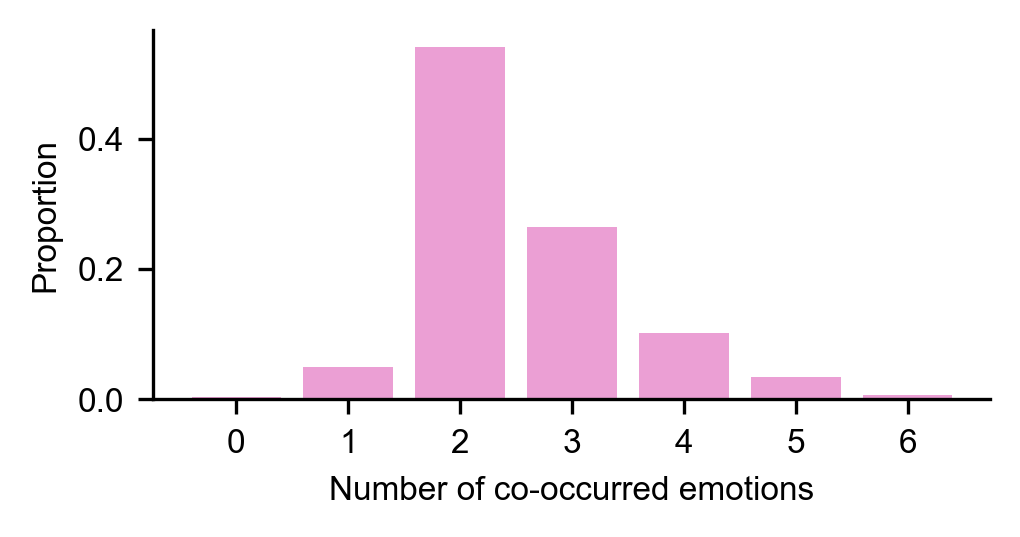

2.75


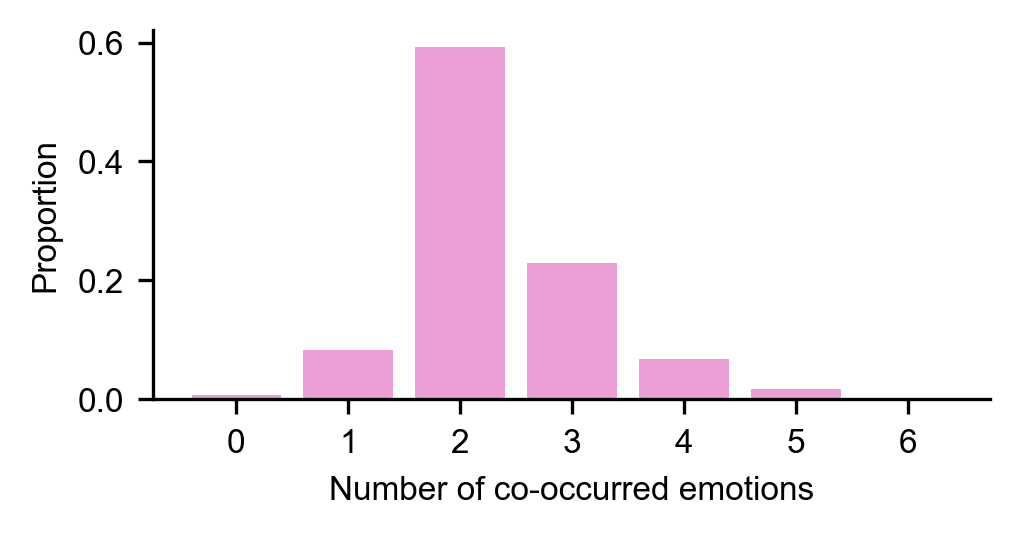

3.0


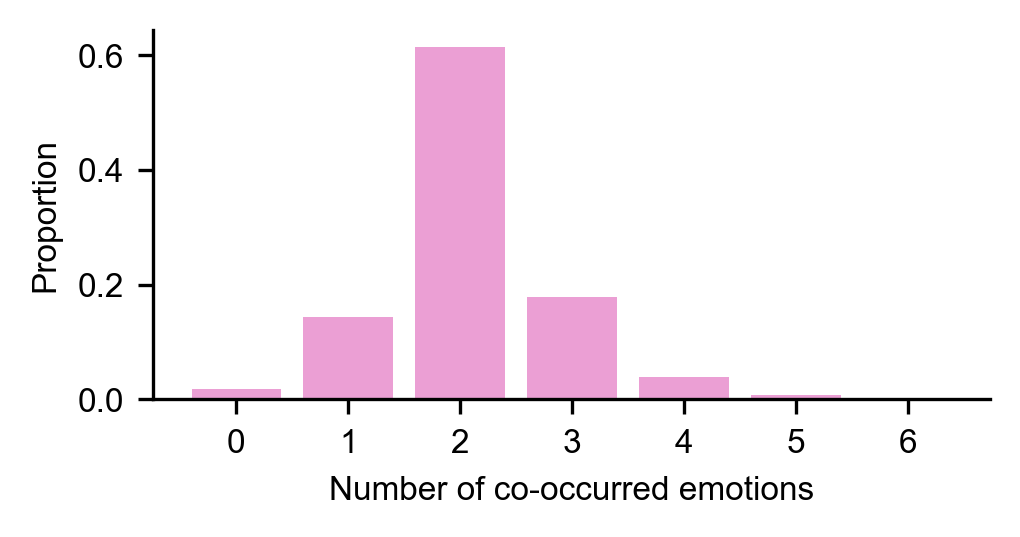

3.25


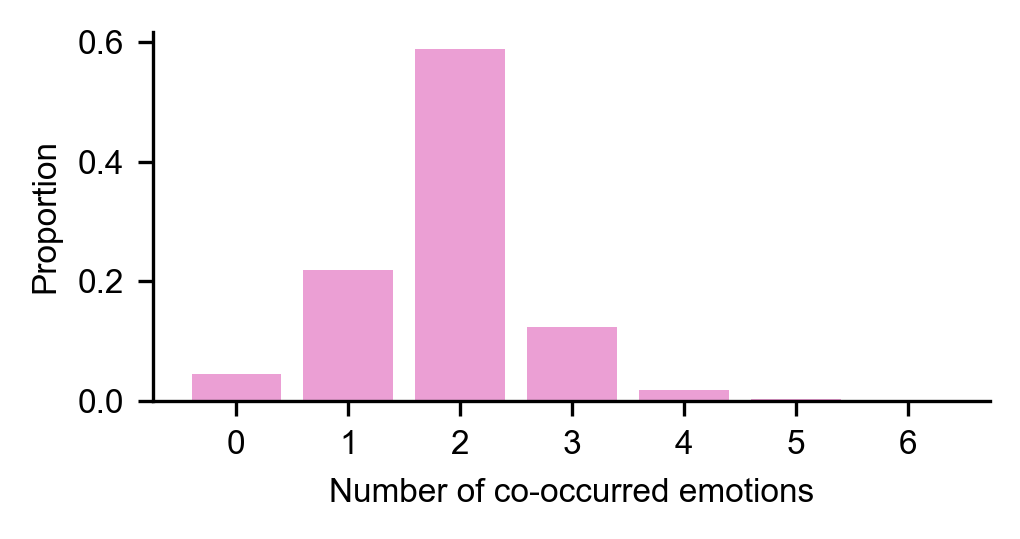

3.5


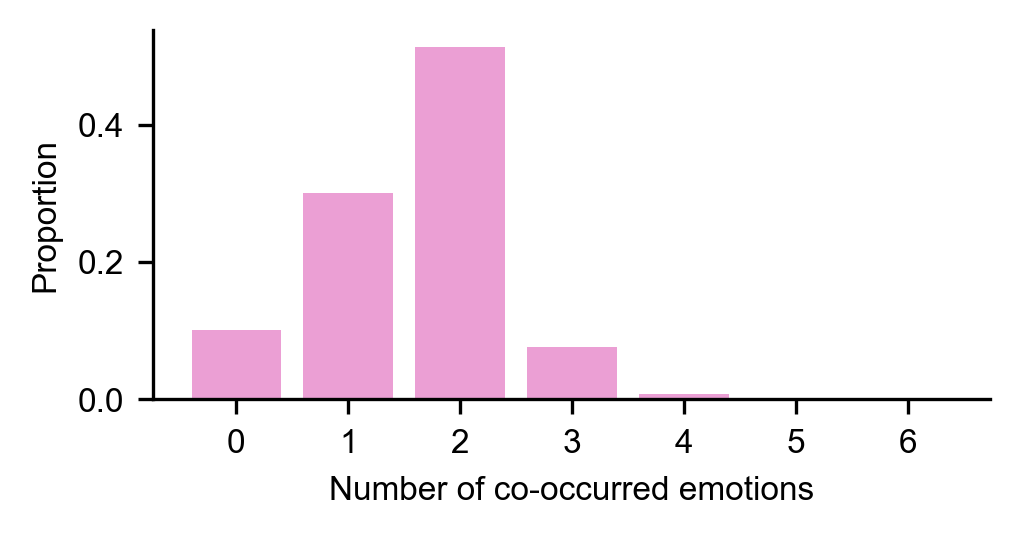

3.75


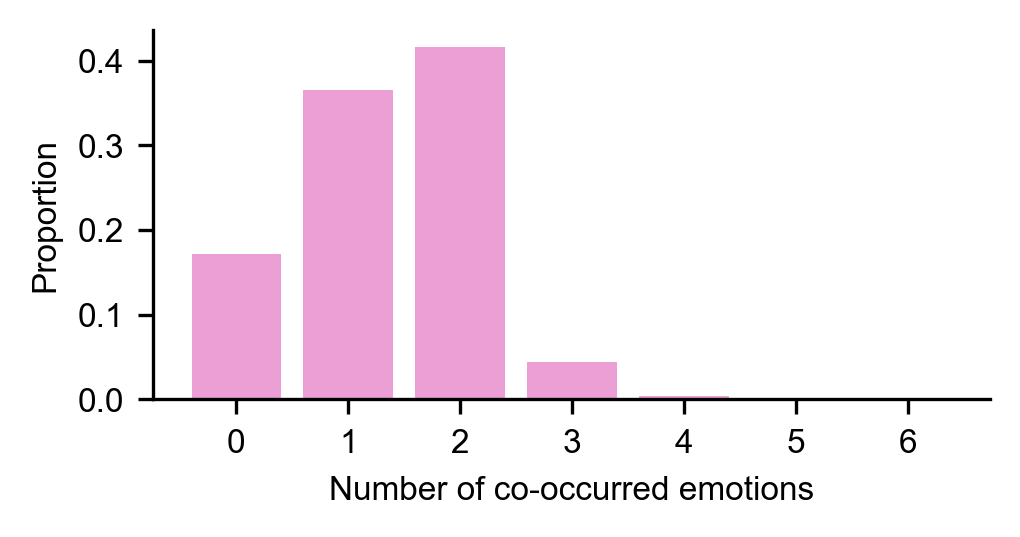

4.0


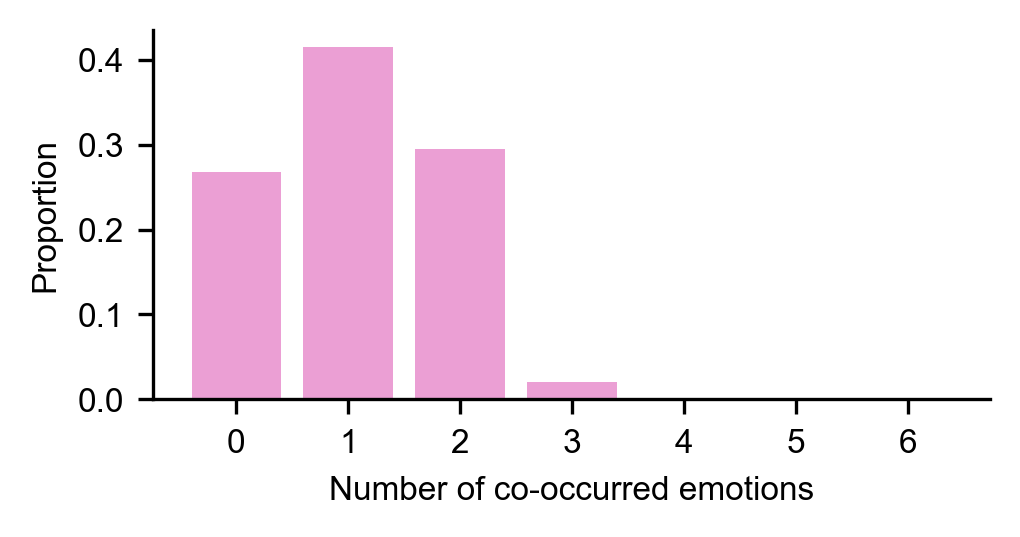

4.25


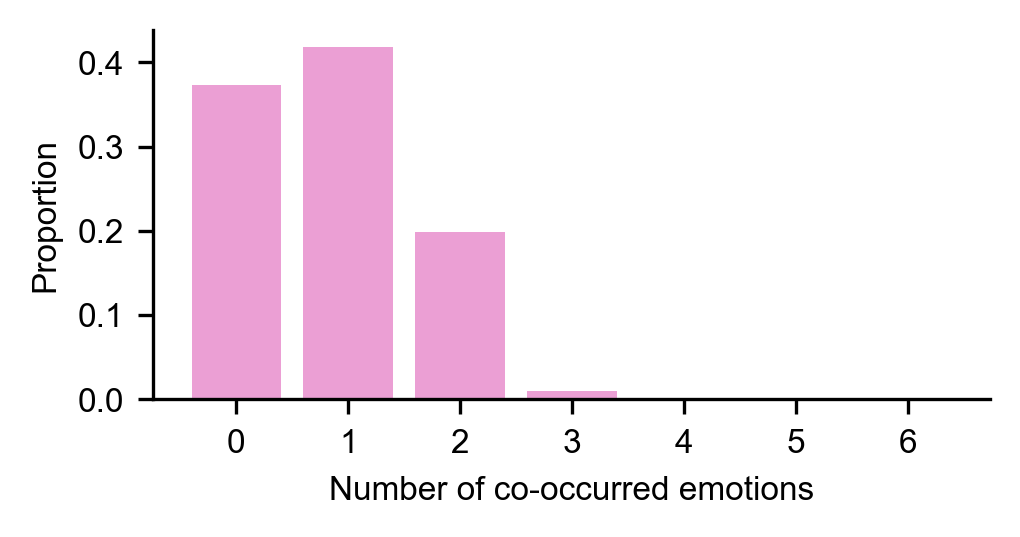

4.5


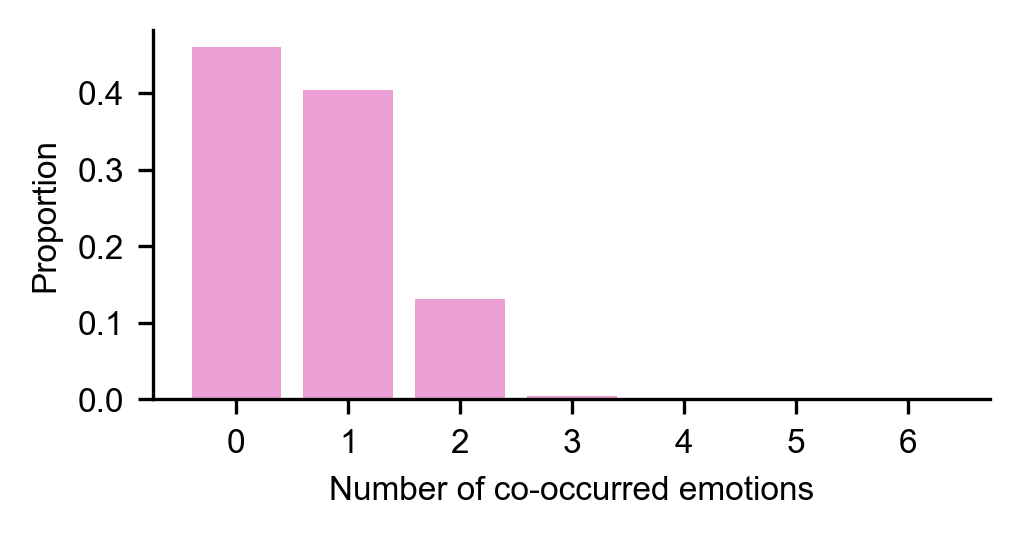

4.75


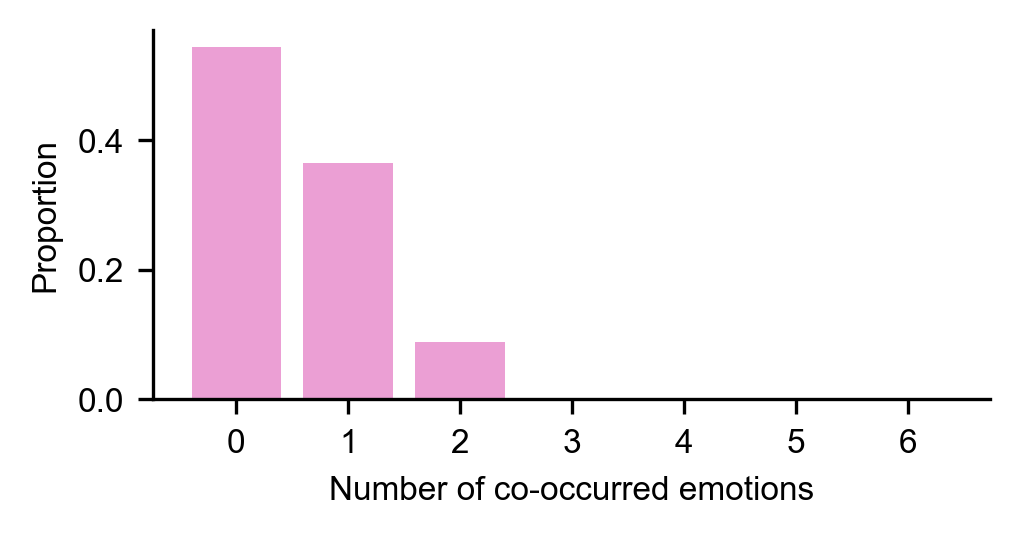

5.0


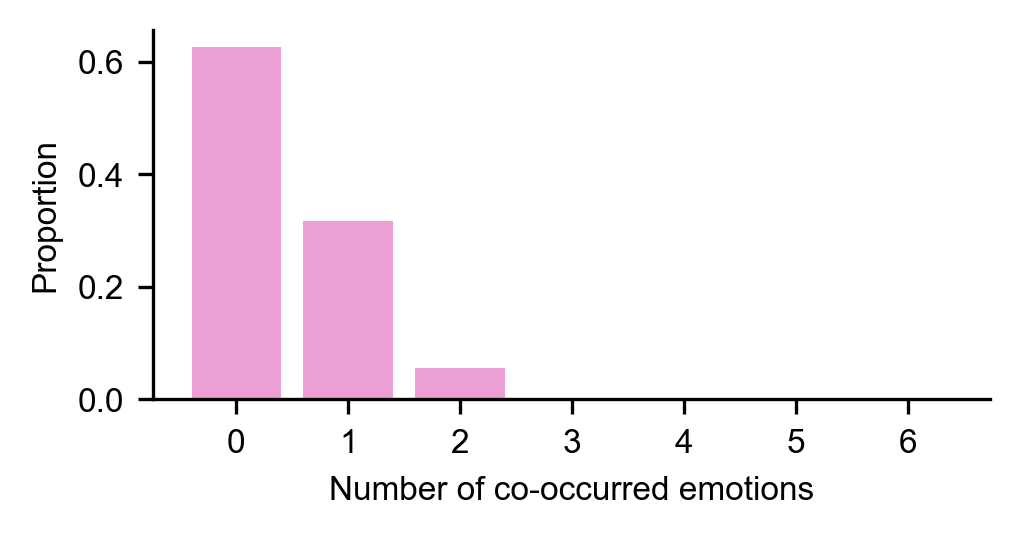

5.25


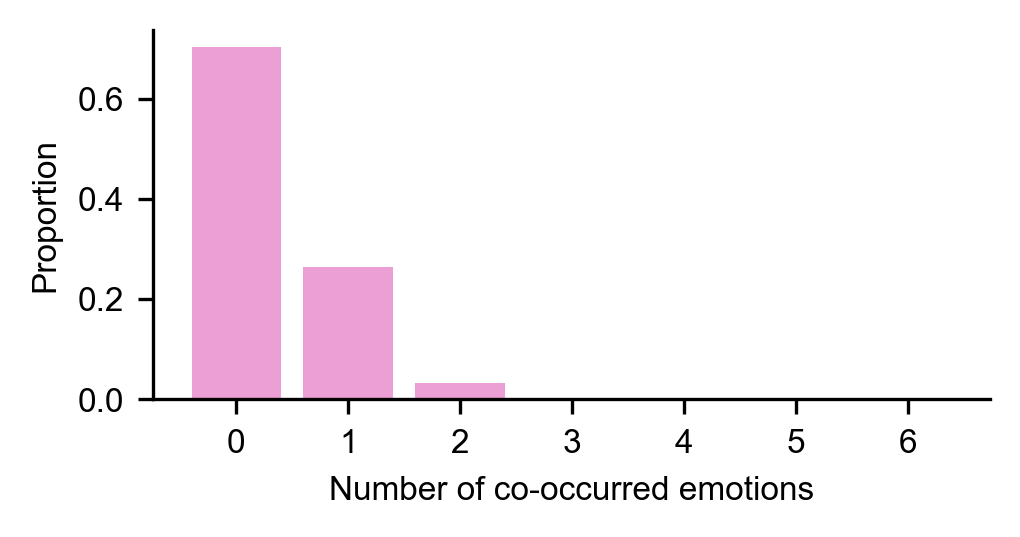

In [419]:
for sel_thr_ind in range(len(thresholds)):
    print(thresholds[sel_thr_ind])
    fig, ax = plt.subplots(figsize=(3.6,1.6), dpi=300)
    plt.bar(np.arange(7), prop_thr[sel_thr_ind,:], color=COLOR_REAL, alpha=0.7)
    plt.xticks(np.arange(7), np.arange(7), fontsize=8)
    plt.ylabel('Proportion', fontsize=8)
    plt.xlabel('Number of co-occurred emotions', fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=8)
    # plt.savefig('figures/figS_proportion_number.jpg', bbox_inches='tight')
    plt.show()

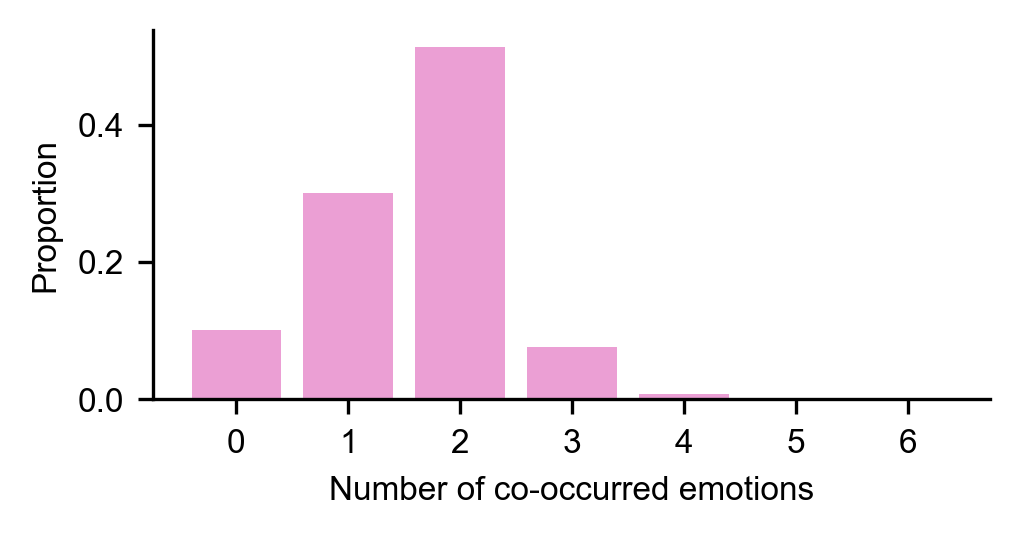

In [414]:
sel_thr_ind = 4
fig, ax = plt.subplots(figsize=(3.6,1.6), dpi=300)
plt.bar(np.arange(7), prop_thr[sel_thr_ind,:], color=COLOR_REAL, alpha=0.7)
plt.xticks(np.arange(7), np.arange(7), fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.xlabel('Number of co-occurred emotions', fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=8)
plt.savefig('figures/figS_proportion_number.jpg', bbox_inches='tight')
plt.show()

Threshold: 3.5
Number of emotions co-occur: 0


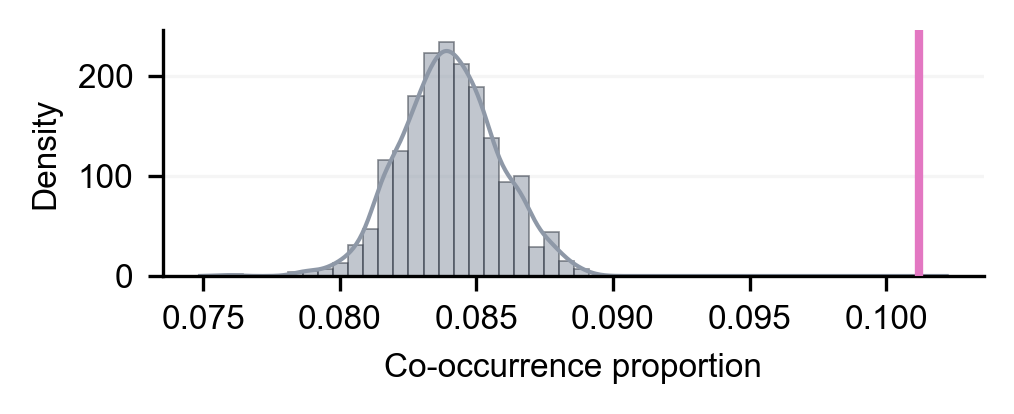

Number of emotions co-occur: 1


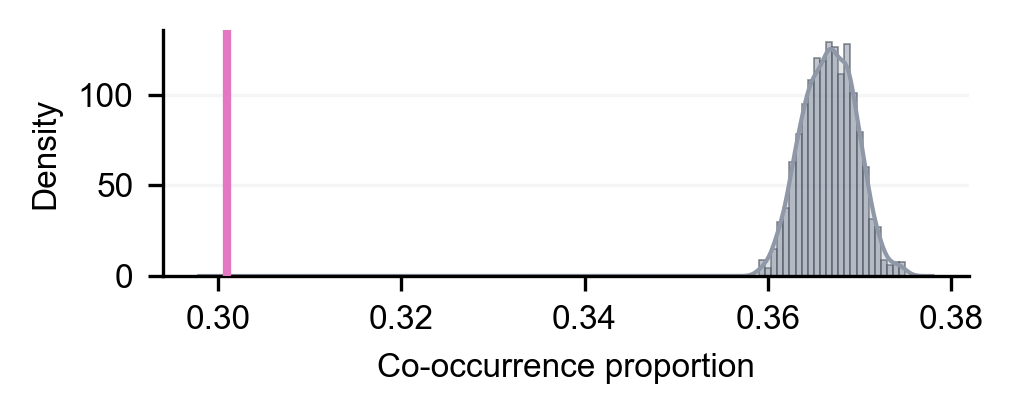

Number of emotions co-occur: 2


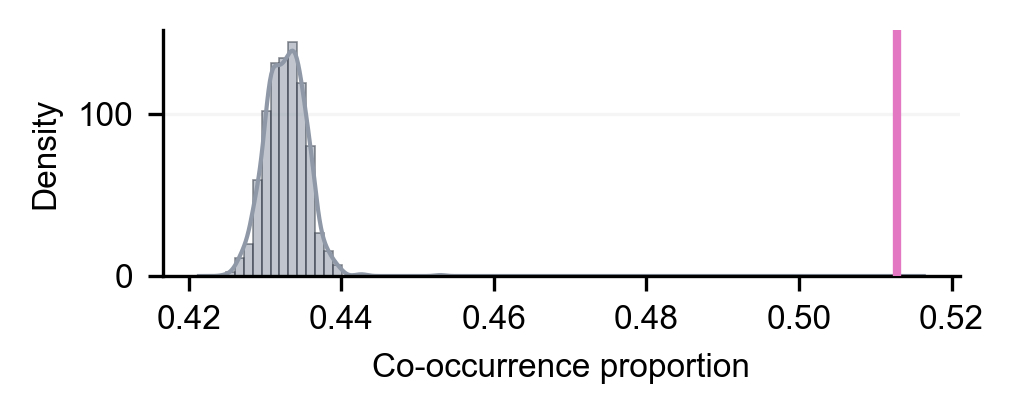

Number of emotions co-occur: 3


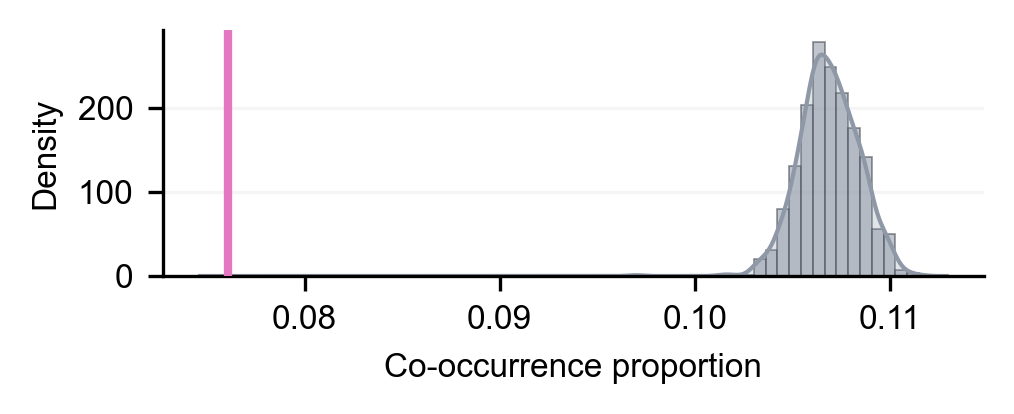

Number of emotions co-occur: 4


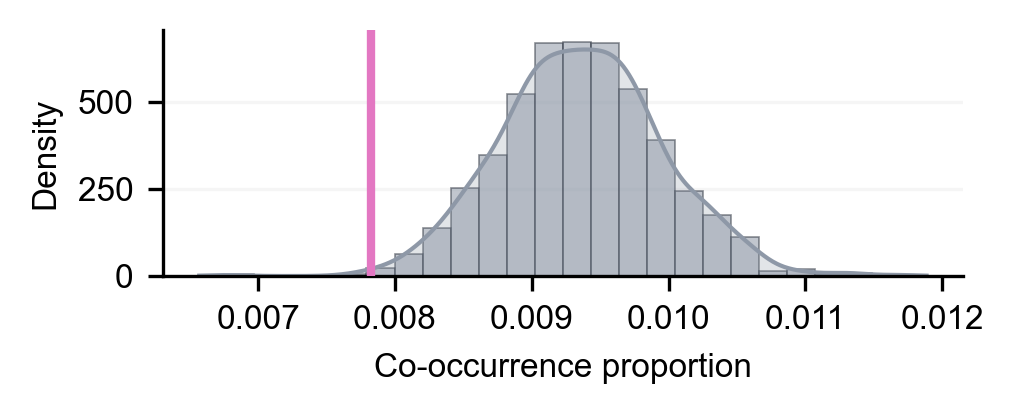

Number of emotions co-occur: 5


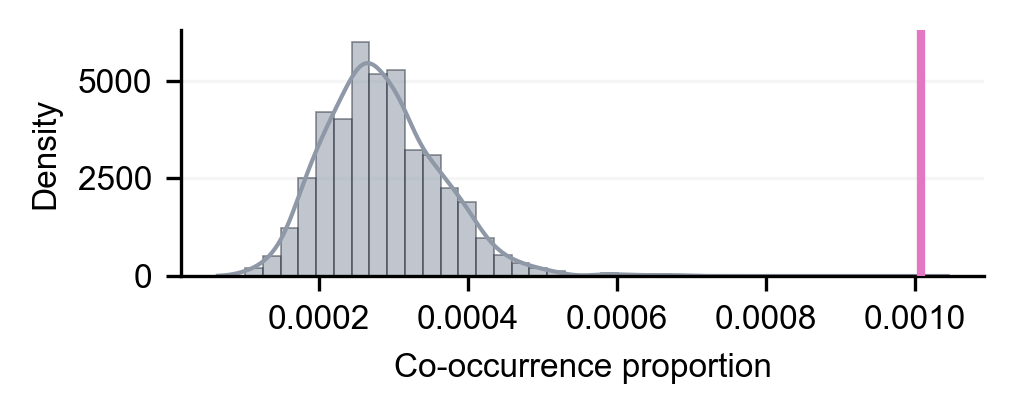

Number of emotions co-occur: 6


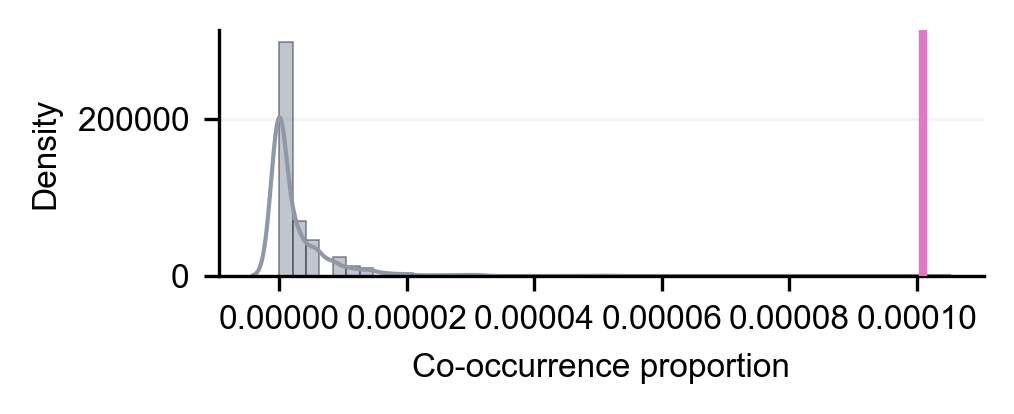

In [403]:
sel_thr_ind = 4
print('Threshold:', tmp[sel_thr_ind])
for emoNum in range(7):
    random_distr = prop_thr_shuffle[:,sel_thr_ind,emoNum]
    real_proportion = prop_thr[sel_thr_ind,emoNum]
    print('Number of emotions co-occur:', emoNum)
    fig, ax, p = plot_real_vs_shuffled(random_distr, real_proportion, figsize=(3.6, 1.6),
                                    xlabel="Co-occurrence proportion",
                                    alternative="greater",
                                    savepath="figures/real_vs_shifted_distribution_emoNum%d.svg" % emoNum)
    plt.show()

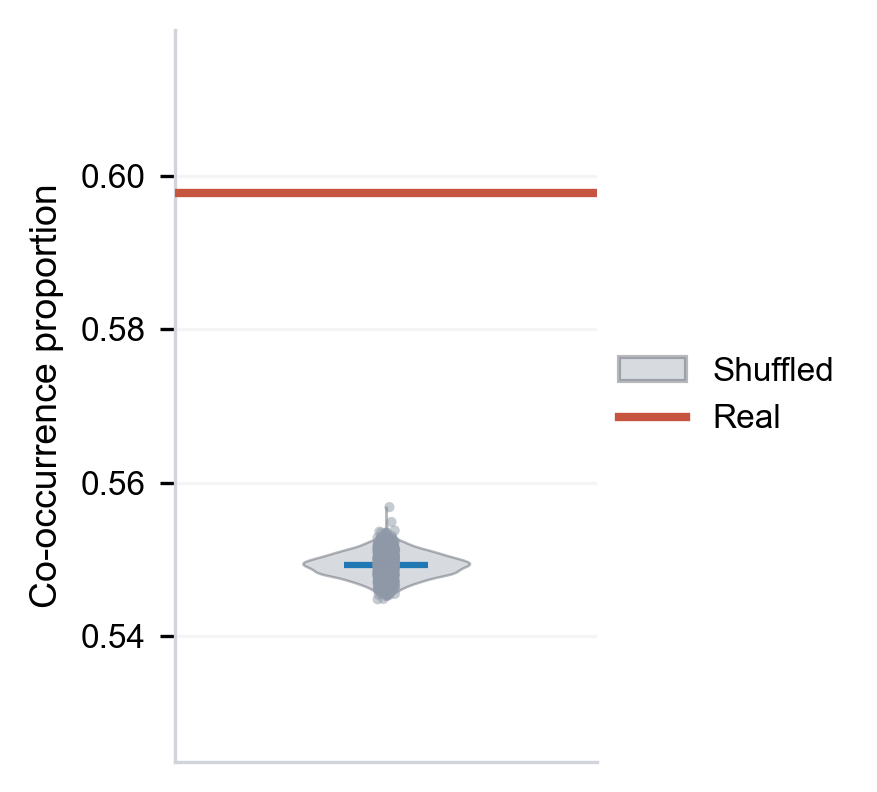

In [ ]:
# previous version
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# —— 统一配色（与你的其它图一致） ——
COLOR_SHUFFLED = "#8E98A7"   # violin 填充
COLOR_REAL     = "#C6543F"   # 真实值横线
EDGE_COLOR     = "#2E3440"
SPINE_COLOR    = "#D1D5DB"

def violin_real_vs_shuffled(random_distr, real_proportion,
                            ylabel="Co-occurrence proportion",
                            alternative="greater",     # 可选：返回置换 p 值
                            quantiles=[0.5],
                            show_points=True,         # 需要散点就 True
                            savepath=None,
                            figsize=(3.8, 2.8), dpi=300):
    rd = np.asarray(random_distr, float).ravel()
    real = float(real_proportion)
    n = len(rd)

    # 经验 p 值（置换检验）
    p_right = (np.sum(rd >= real) + 1) / (n + 1)
    p_left  = (np.sum(rd <= real) + 1) / (n + 1)
    p = {"greater": p_right, "less": p_left, "two-sided": min(1.0, 2*min(p_left, p_right))}[alternative]

    # 画图
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    parts = ax.violinplot(
        dataset=[rd],
        positions=[0],
        showextrema=False,          # 不画极值“触角”
        showmeans=False,
        showmedians=False,
        vert=True,
        widths=0.75,
        quantiles=[[q for q in quantiles]] if quantiles else None
    )
    # 小提琴样式
    for pc in parts['bodies']:
        pc.set_facecolor(COLOR_SHUFFLED)
        pc.set_edgecolor(EDGE_COLOR)
        pc.set_linewidth(0.6)
        pc.set_alpha(0.35)

    # quantiles 线（若有）
    # if quantiles:
    #     qlines = parts.get('cquantiles', [])
    #     for ql in qlines:
    #         ql.set_color(COLOR_SHUFFLED)
    #         ql.set_linewidth(1.0)
    #         ql.set_alpha(0.9)

    # 可选：在小提琴上叠加少量抖动点（更直观地看分布密度）
    if show_points:
        rng = np.random.default_rng(42)
        xj = 0.08 * (rng.random(n) - 0.5)  # 轻微横向抖动
        ax.scatter(np.zeros(n) + xj, rd, s=6, color=COLOR_SHUFFLED, alpha=0.5, edgecolors='none', zorder=2)

    # 真实值横线（跨整幅）
    ax.axhline(real, color=COLOR_REAL, lw=2.0, zorder=3)

    # 轴样式（子刊风）
    pad = 0.4 * (max(rd.max(), real) - min(rd.min(), real) + 1e-12)
    ax.set_ylim(min(rd.min(), real)-pad, max(rd.max(), real)+pad)
    ax.set_xlim(-0.95, 0.95)
    ax.set_xticks([])

    ax.set_ylabel(ylabel, fontsize=9)
    ax.yaxis.grid(True, linestyle='-', alpha=0.12)
    ax.set_axisbelow(True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.spines["left"].set_color(SPINE_COLOR)
    ax.spines["bottom"].set_color(SPINE_COLOR)
    ax.tick_params(labelsize=8)

    # 图例放图外（右侧）
    handles = [
        Patch(facecolor=COLOR_SHUFFLED, edgecolor=EDGE_COLOR, alpha=0.35, label="Shuffled"),
        Line2D([0],[0], color=COLOR_REAL, lw=2.0, label="Real")
    ]
    ax.legend(handles=handles, frameon=False, fontsize=8,
              loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.tight_layout(rect=(0, 0, 0.82, 1))

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    return fig, ax, p

# ===== 用法示例 =====
random_distr = random_distributions[3.5]
real_proportion = real_proportions[4]
fig, ax, p = violin_real_vs_shuffled(random_distr, real_proportion,
                                     ylabel="Co-occurrence proportion",
                                     alternative="greater",
                                     savepath="figures/real_vs_shifted_violin.svg")
plt.show()


In [61]:
thr = 3.5
X_data = scores_all
data_thr = (X_data > thr).astype(int)

In [64]:
cooccur_mat = np.zeros((6,6))
for i in range(6):
    for j in range(i+1,6):
        cooccur_mat[i,j] = np.sum((data_thr[:, i] > 0) & (data_thr[:,j] > 0)) / data_thr.shape[0]

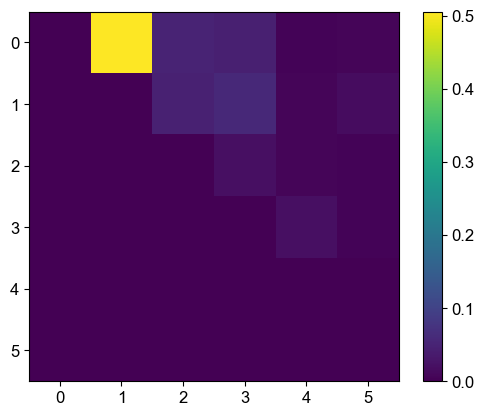

In [66]:
plt.imshow(cooccur_mat)
plt.colorbar()
plt.show()

In [148]:
segments = []
for i in range(102):
    segments.append((n_samples_cum[i], n_samples_cum[i+1]))

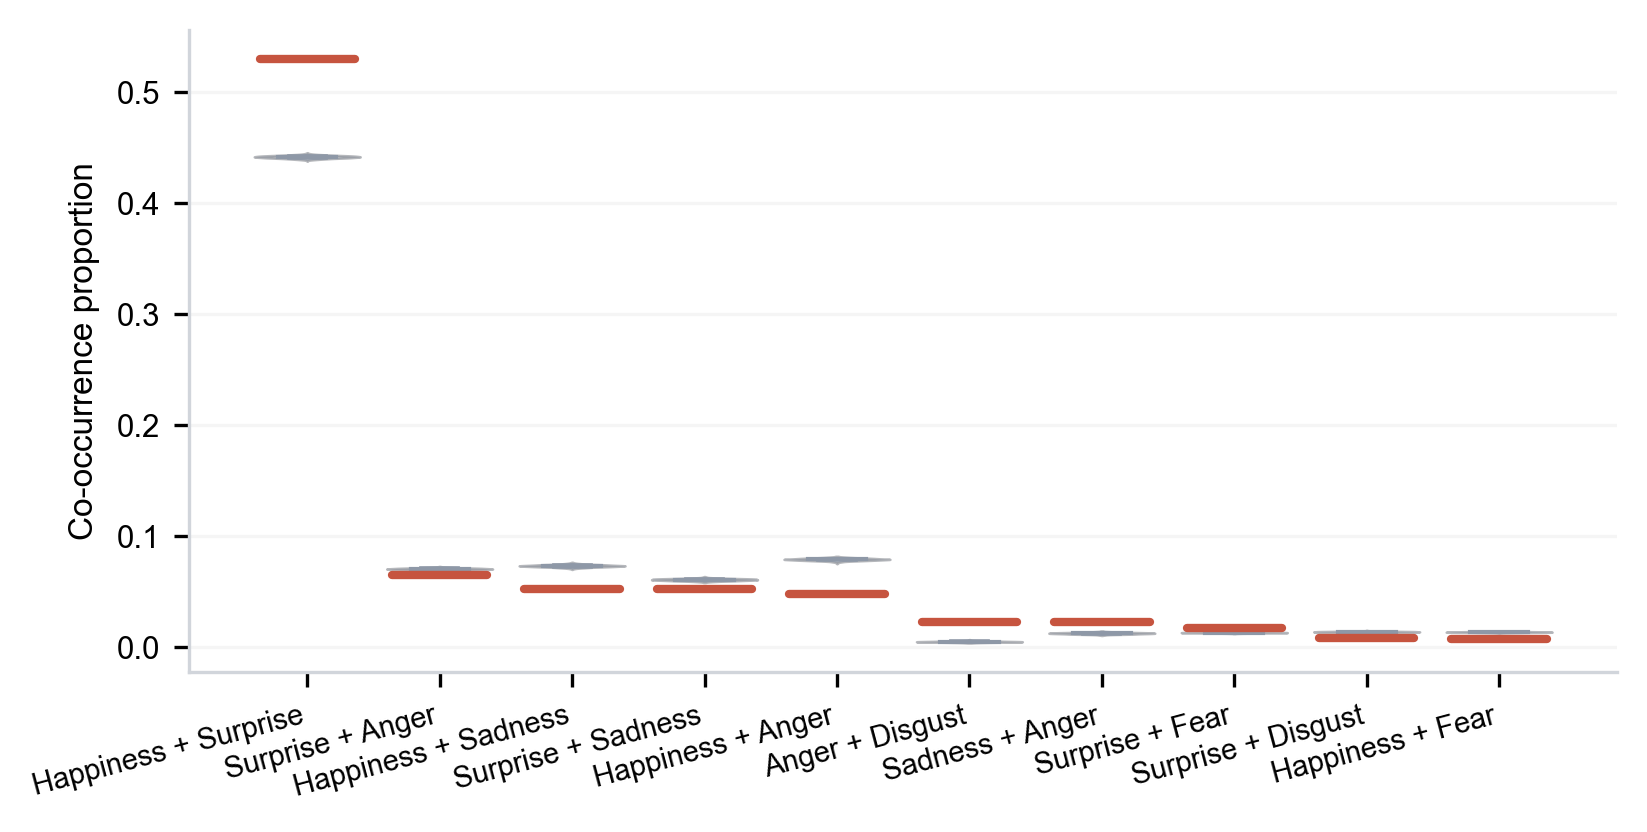

Top pairs: [(0, 1), (1, 3), (0, 2), (1, 2), (0, 3), (3, 4), (2, 3), (1, 5), (1, 4), (0, 5)] Real props: [0.52953101 0.0651378  0.05223378 0.05218605 0.04794367 0.02244727
 0.0220177  0.01737944 0.00774915 0.00708935]


In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 你已有的情绪名与配色（配色只用于legend，不影响小提琴色）
EMO_NAMES = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
COLOR_SHUFFLED = "#8E98A7"   # violin 填充
COLOR_REAL     = "#C6543F"   # 真实值横线
EDGE_COLOR     = "#2E3440"
SPINE_COLOR    = "#D1D5DB"

def _pair_indices(n=6):
    return [(i, j) for i in range(n) for j in range(i+1, n)]

def _circ_roll_segment(x, shift):
    """对一段向量做循环时移（避免跨片段串扰时可分段处理）"""
    if shift == 0: return x
    shift %= len(x)
    return np.concatenate([x[-shift:], x[:-shift]])

def pair_coocc_prop(scores, i, j, thr, segments=None):
    """
    计算 (i,j) 两维同时≥thr 的时间点比例；可选分段以避免跨影片 wrap。
    scores: (T, D)
    segments: None 或 [(s0,e0), (s1,e1), ...]
    """
    if segments is None:
        m = (scores[:, i] >= thr) & (scores[:, j] >= thr)
        return m.mean()
    # 分段求和更稳健
    num = 0; den = 0
    for (s, e) in segments:
        m = (scores[s:e, i] >= thr) & (scores[s:e, j] >= thr)
        num += m.sum(); den += (e - s)
    return num / max(1, den)

def pair_coocc_prop_shifted(scores, i, j, thr, B=1000, rng=None, segments=None):
    """
    循环时移代理：对两维分别随机相位后，计算同时≥thr 的比例；重复 B 次得到分布。
    若提供 segments，则在每个片段内独立循环时移。
    """
    if rng is None: rng = np.random.default_rng()
    T = scores.shape[0]
    out = np.empty(B, float)

    if segments is None:
        xi, xj = scores[:, i], scores[:, j]
        for b in range(B):
            si = int(rng.integers(1, T))    # 避免 0 位移
            sj = int(rng.integers(1, T))
            mi = np.roll(xi, si) >= thr
            mj = np.roll(xj, sj) >= thr
            out[b] = np.mean(mi & mj)
        return out

    # 分段版本
    for b in range(B):
        num = 0; den = 0
        for (s, e) in segments:
            L = e - s
            si = int(rng.integers(1, L)); sj = int(rng.integers(1, L))
            xi = _circ_roll_segment(scores[s:e, i], si) > thr
            xj = _circ_roll_segment(scores[s:e, j], sj) > thr
            num += np.sum(xi & xj); den += L
        out[b] = num / max(1, den)
    return out

def violin_pairs_cooccurrence(scores_all,
                              thr=3.5, top_k=2, B=1000,
                              segments=None,           # 若 scores_all 为多片段拼接，可传 [(s,e),...]
                              ylabel="Co-occurrence proportion",
                              savepath=None, figsize=(3.6, 2.8), dpi=300):
    """
    找出共现比例最高的 top_k 个情绪对，画：循环时移分布的小提琴 + 真实值横线
    """
    plt.rcParams['font.size'] = 7.5
    D = scores_all.shape[1]
    pairs = _pair_indices(D)

    # 1) 真实共现比例（所有 pair）
    props_real = []
    for (i,j) in pairs:
        props_real.append(pair_coocc_prop(scores_all, i, j, thr, segments))
    props_real = np.array(props_real)
    top_idx = np.argsort(props_real)[::-1][:top_k]
    chosen = [pairs[k] for k in top_idx]

    # 2) 代理分布
    rng = np.random.default_rng(2025)
    shifted_dists = []
    for (i,j) in chosen:
        shifted = pair_coocc_prop_shifted(scores_all, i, j, thr, B=B, rng=rng, segments=segments)
        shifted_dists.append(shifted)

    # 3) 画图
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    positions = np.arange(top_k)

    parts = ax.violinplot(shifted_dists, positions=positions, vert=True,
                          showextrema=False, showmeans=False, showmedians=False, widths=0.8)
    for bd in parts['bodies']:
        bd.set_facecolor(COLOR_SHUFFLED)
        bd.set_edgecolor(EDGE_COLOR)
        bd.set_linewidth(0.6)
        bd.set_alpha(0.35)

    # 四分位（用简单分位线代替内线）
    for pos, dist in zip(positions, shifted_dists):
        q25, q50, q75 = np.quantile(dist, [0.25, 0.5, 0.75])
        ax.plot([pos-0.22, pos+0.22], [q50, q50], color=COLOR_SHUFFLED, lw=1.0)  # median
        ax.plot([pos-0.14, pos+0.14], [q25, q25], color=COLOR_SHUFFLED, lw=0.9, alpha=0.9)
        ax.plot([pos-0.14, pos+0.14], [q75, q75], color=COLOR_SHUFFLED, lw=0.9, alpha=0.9)

    # 真实值横线
    for pos, k in zip(positions, top_idx):
        ax.plot([pos-0.36, pos+0.36], [props_real[k], props_real[k]],
                color=COLOR_REAL, lw=2.0, solid_capstyle="round", zorder=3)

    # x 轴标签：情绪组合
    xticklabels = [f"{EMO_NAMES[i]} + {EMO_NAMES[j]}" for (i,j) in chosen]
    ax.set_xticks(positions)
    ax.set_xticklabels(xticklabels, rotation=15, ha="right", fontsize=7)

    # y 轴 & 样式
    ax.set_ylabel(ylabel, fontsize=8)
    ax.yaxis.grid(True, linestyle='-', alpha=0.12)
    ax.set_axisbelow(True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.spines["left"].set_color(SPINE_COLOR)
    ax.spines["bottom"].set_color(SPINE_COLOR)
    # ax.tick_params(labelsize=8)

    # 图例放图外
    # handles = [
    #     Patch(facecolor=COLOR_SHUFFLED, edgecolor=EDGE_COLOR, alpha=0.35, label="Shifted distribution"),
    #     Line2D([0],[0], color=COLOR_REAL, lw=2.0, label="Real value")
    # ]
    # ax.legend(handles=handles, frameon=False, fontsize=8,
    #           loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.tight_layout(rect=(0, 0, 0.78, 1))

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    return fig, ax, {"pairs": chosen, "real_props": props_real[top_idx], "shifted": shifted_dists}

# ===== 用法示例 =====
# scores_all: 形状 (T,6) 的情绪时间序列（连续拼接也可）
# 如有多影片拼接，传 segments = [(s0,e0), (s1,e1), ...]，避免跨片段循环时移。
fig, ax, info = violin_pairs_cooccurrence(scores_all, thr=3.5, top_k=10, B=1000,
                                          segments=segments, figsize=(7, 2.8),
                                          savepath="figures/violin_top2_pairs.svg")
plt.show()
print("Top pairs:", info["pairs"], "Real props:", info["real_props"])


In [81]:
# Forrest Gump, Let The Bullets Fly, Batman Dark Knight, World War Z 
scores_dict.keys()

dict_keys(['Batman_darknight', 'Be_somebody', 'forrest_gump', 'Gashapon', 'Godzilla', 'Green_book', 'Harry_potter', 'Heidi', 'Kong_fu', 'let_bullet_fly_reorder', 'Luo_xiao_hei', 'The_bad_guys', 'The_Shawshank_Redemption', 'The_Wandering_Earth_II', 'Weathering_With_You', 'White_snake', 'World_War_Z', 'Yang_jian', 'BV1134y1g7Vq', 'BV11x4y117NY', 'BV147411y71D', 'BV14b411c72z', 'BV14E411C7Lf', 'BV14T4y1u7ST', 'BV163411i7Un', 'BV164411k73g', 'BV16e4y1P7sa', 'BV17f4y1n7et', 'BV17h411D7aX', 'BV17W411r78v', 'BV17W411Z7Lh', 'BV18E411e7By', 'BV191421B7B9', 'BV19x41127Nd', 'BV1BJ411S7Ch', 'BV1bL411578p', 'BV1bz4y1a7QZ', 'BV1cW411a7ed', 'BV1Ds411V7cP', 'BV1dU4y1g73N', 'BV1Dx411u7jw', 'BV1e4411k74a', 'BV1E4411U7Qu', 'BV1ED4y1j7Jn', 'BV1Ee4y1B74h', 'BV1eJ411B7to', 'BV1Fb411F7fk', 'BV1Fb411z7Zy', 'BV1ht4y1D7tG', 'BV1j4411X7CV', 'BV1j44y1y7YQ', 'BV1kJ411j7pH', 'BV1kK4y1b7dH', 'BV1Kx411p7hz', 'BV1ky4y167Tg', 'BV1Lp411R7Fx', 'BV1LP4y1H7TJ', 'BV1M7411J7kP', 'BV1ms411U75B', 'BV1mw4m1e7BD', 'BV1na4y1Y7rR'

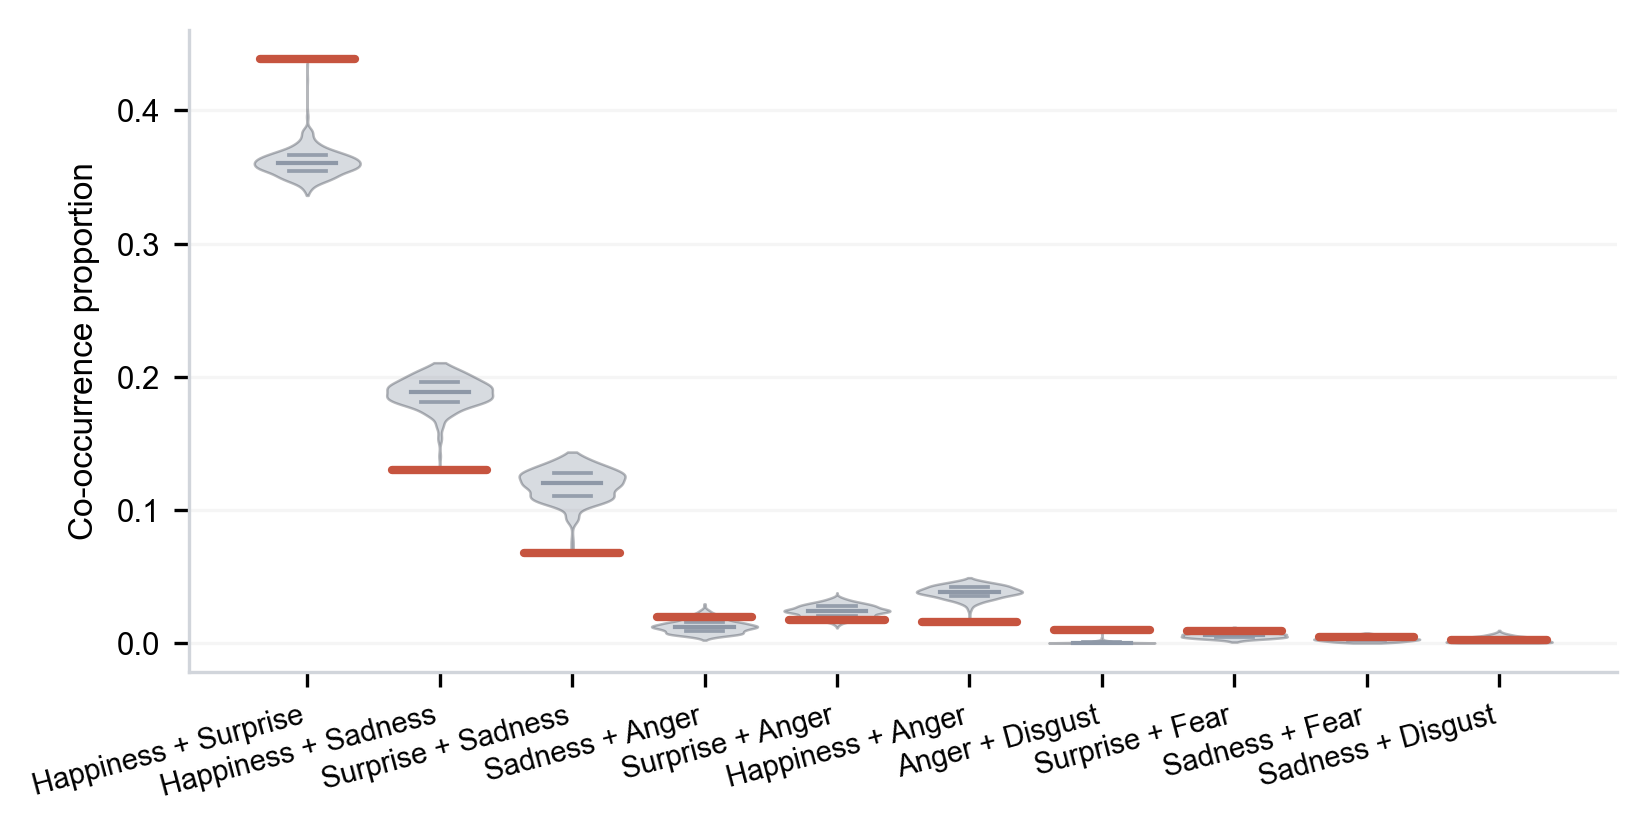

forrest_gump Top pairs: [(0, 1), (0, 2), (1, 2), (2, 3), (1, 3), (0, 3), (3, 4), (1, 5), (2, 5), (2, 4)] Real props: [0.43883357 0.12991939 0.06733049 0.01967757 0.01730678 0.01541015
 0.00995733 0.00900901 0.00426743 0.00260787]


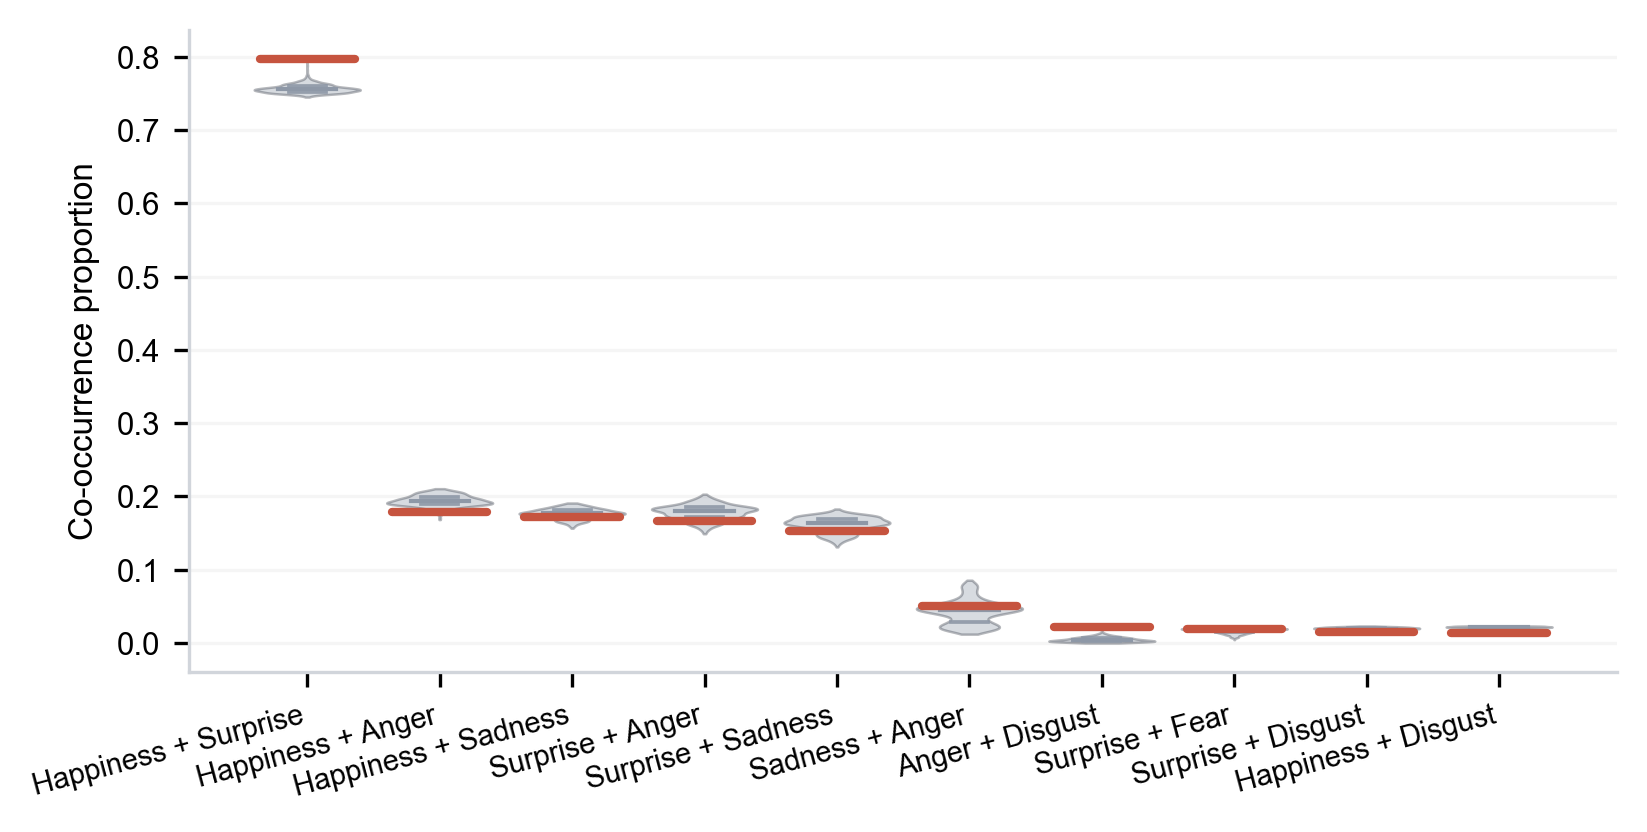

White_snake Top pairs: [(0, 1), (0, 3), (0, 2), (1, 3), (1, 2), (2, 3), (3, 4), (1, 5), (1, 4), (0, 4)] Real props: [0.79725311 0.17822106 0.17233486 0.16612165 0.15336821 0.0500327
 0.02158273 0.01863963 0.01438849 0.01406148]


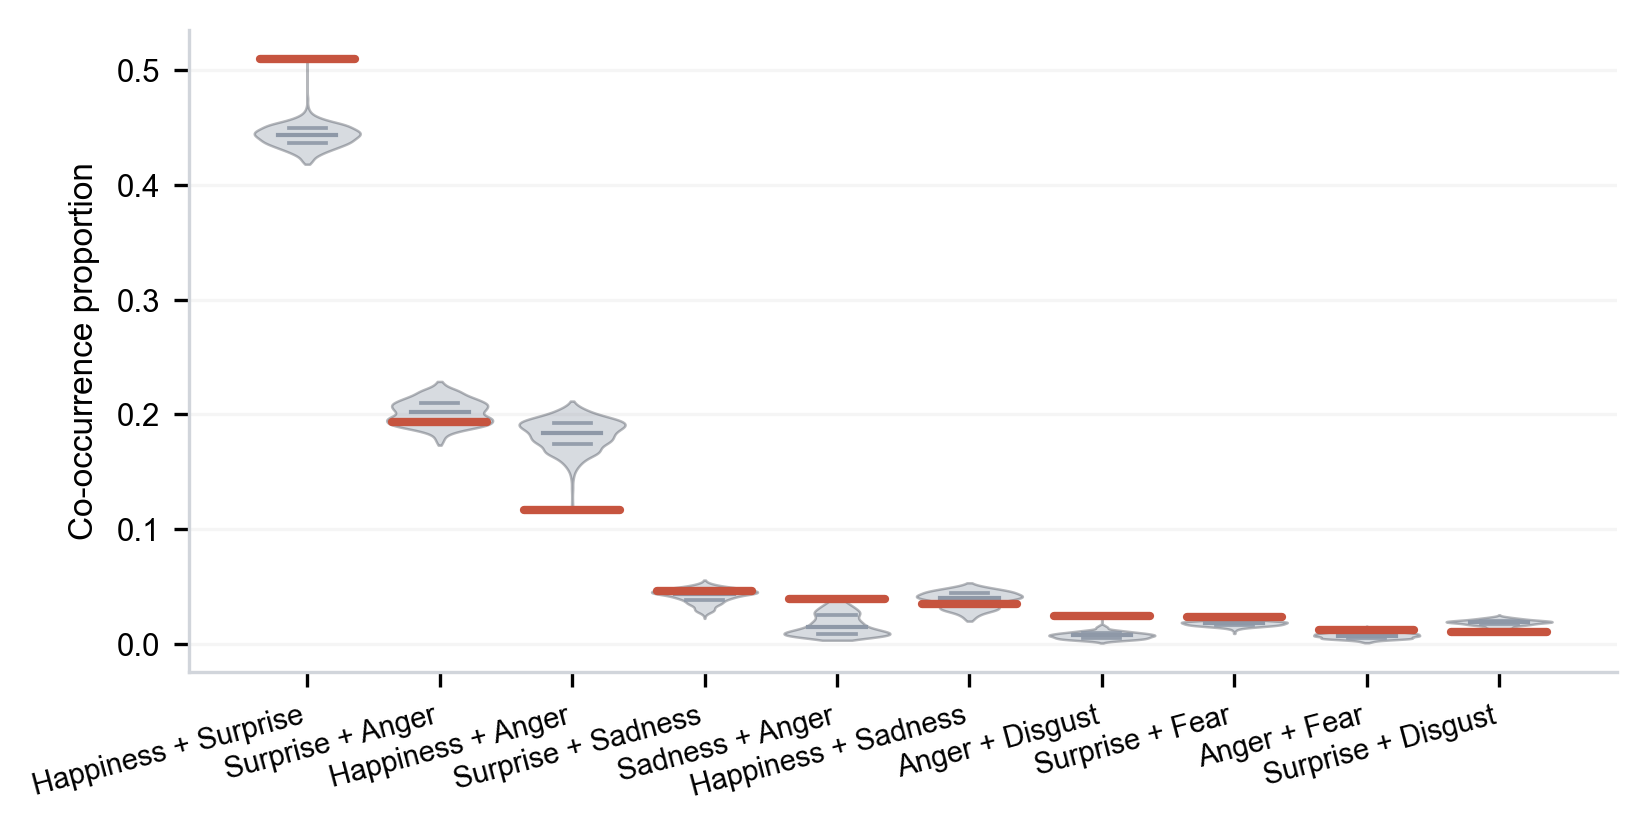

Batman_darknight Top pairs: [(0, 1), (1, 3), (0, 3), (1, 2), (2, 3), (0, 2), (3, 4), (1, 5), (3, 5), (1, 4)] Real props: [0.50952903 0.19342826 0.116977   0.04665936 0.03899233 0.03461117
 0.02431544 0.02365827 0.01226725 0.01073384]


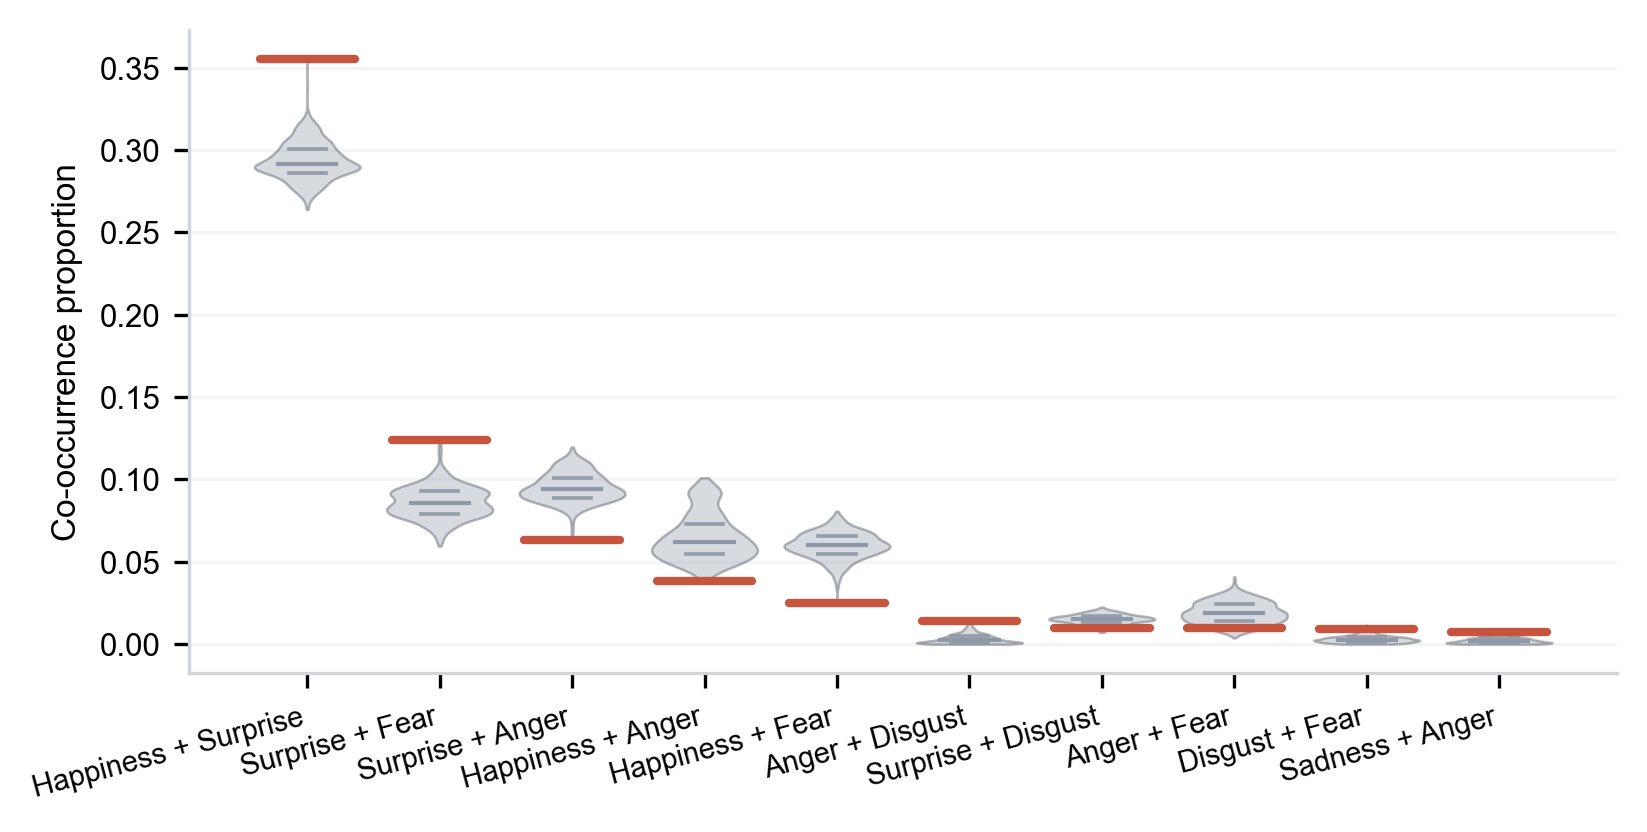

World_War_Z Top pairs: [(0, 1), (1, 5), (1, 3), (0, 3), (0, 5), (3, 4), (1, 4), (3, 5), (4, 5), (2, 3)] Real props: [0.35536295 0.12378115 0.06310943 0.03819068 0.02491874 0.01381365
 0.01002167 0.00975081 0.00947996 0.00731311]


In [91]:
scores_sel = {}
sel_keys = ['forrest_gump', 'White_snake', 'Batman_darknight', 'World_War_Z']
for key in sel_keys:
    scores_sel[key] = scores_dict[key]
    fig, ax, info = violin_pairs_cooccurrence(scores_sel[key], thr=3.5, top_k=10, B=1000,
                                            segments=None, figsize=(7, 2.8),
                                            savepath="figures/violin_top2_pairs_%s.svg" % key)
    plt.show()
    print(key, "Top pairs:", info["pairs"], "Real props:", info["real_props"])

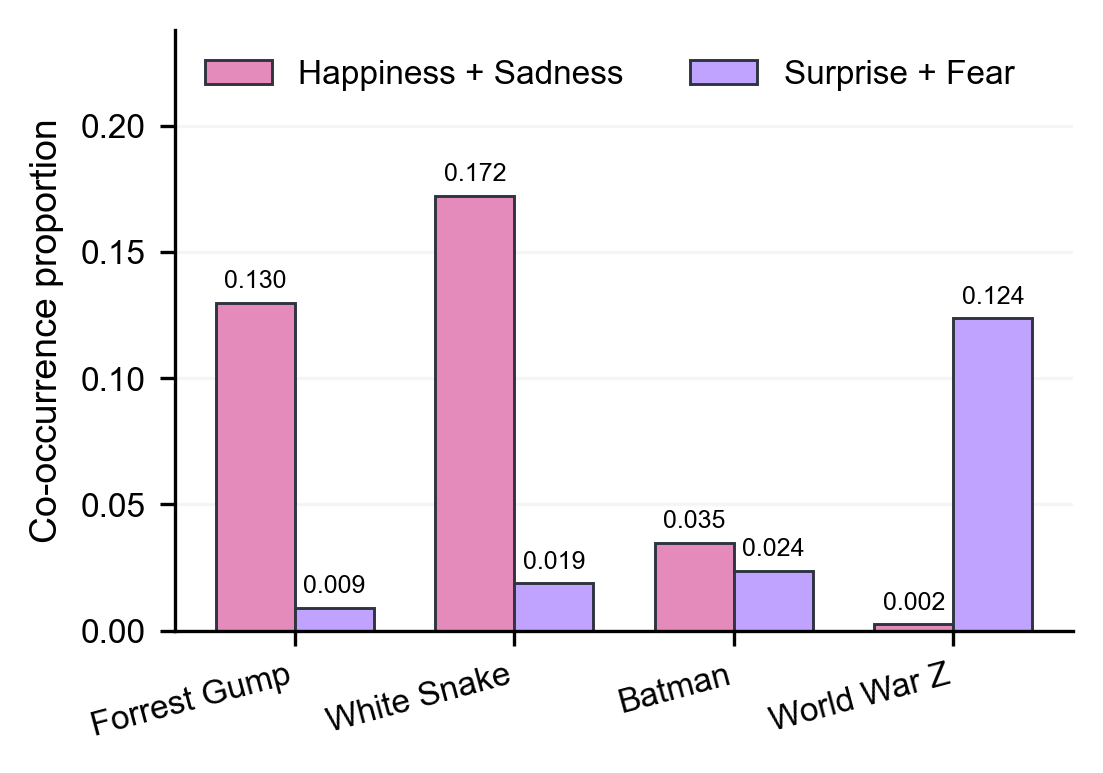

In [341]:
PAIR_COLORS = {
    "HS": "#E58BBB",  # Surprise + Fear
    "SF": "#BFA3FF",  # 柔和淡紫
}

pretty_name = {
    "forrest_gump": "Forrest Gump",
    "White_snake": "White Snake",
    "Batman_darknight": "Batman",
    "World_War_Z": "World War Z",
}

def _prop_pair(scores_sel, film_order, i, j, thr):
    return [pair_coocc_prop(scores_sel[k], i, j, thr, segments=None) for k in film_order]

def plot_compact_grouped_coocc(scores_sel, film_order, thr=3.5,
                               figsize=(5.6, 2.6), dpi=300, savepath=None):
    # 组合：Happiness+Sadness (0,2)；Surprise+Fear (1,5)
    props_HS = _prop_pair(scores_sel, film_order, 0, 2, thr)
    props_SF = _prop_pair(scores_sel, film_order, 1, 5, thr)
    labels   = [pretty_name.get(k, k) for k in film_order]

    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x = np.arange(len(film_order))
    w = 0.36

    bars1 = ax.bar(x - w/2, props_HS, width=w, color=PAIR_COLORS["HS"],
                   edgecolor=EDGE_COLOR, linewidth=0.7, label="Happiness + Sadness")
    bars2 = ax.bar(x + w/2, props_SF, width=w, color=PAIR_COLORS["SF"],
                   edgecolor=EDGE_COLOR, linewidth=0.7, label="Surprise + Fear")

    # 数值标注（更紧凑：贴近柱顶，字号小）
    for b in list(bars1) + list(bars2):
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.004, f"{h:.3f}",
                ha="center", va="bottom", fontsize=6)

    # 轴与网格（紧凑风格）
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, ha="right")
    ax.yaxis.grid(True, linestyle='-', alpha=0.12)
    ax.set_axisbelow(True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    # ax.spines["left"].set_color(SPINE_COLOR)
    # ax.spines["bottom"].set_color(SPINE_COLOR)

    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylabel("Co-occurrence proportion", fontsize=9)

    ymax = max(props_HS + props_SF) if len(props_HS + props_SF) else 1.0
    ax.set_ylim(0, min(1.0, ymax * 1.15 + 0.04))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # 紧凑图例：放内侧上方，双列
    leg = ax.legend(loc="upper left", ncol=2, frameon=False, fontsize=8)
    plt.tight_layout(pad=0.8)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    return fig, ax

# —— 调用 ——
fig, ax = plot_compact_grouped_coocc(
    scores_sel=scores_sel,
    film_order=sel_keys,
    thr=3.5,
    figsize=(3.7, 2.6),
    dpi=300,
    savepath="figures/compact_grouped_coocc.svg"
)
plt.show()


Explained variance ratio: [0.55249963 0.22969493 0.11926599 0.06118363 0.0264687  0.01088711]


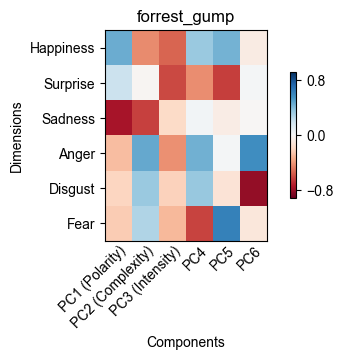

Explained variance ratio: [0.5242119  0.25328417 0.13284918 0.05319922 0.02326835 0.01318718]


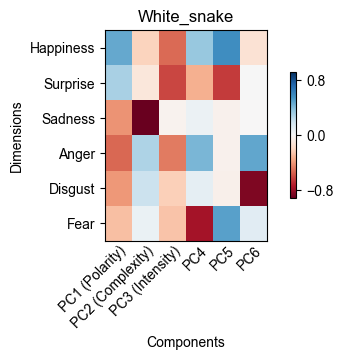

Explained variance ratio: [0.51807031 0.22554768 0.12143811 0.08327254 0.03097164 0.02069973]


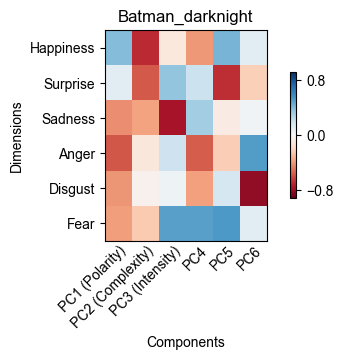

Explained variance ratio: [0.46983971 0.25233248 0.14134958 0.07784627 0.03678276 0.0218492 ]


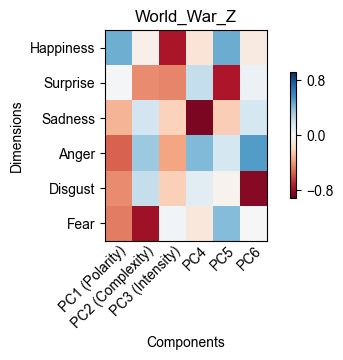

In [322]:
from sklearn.decomposition import PCA
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
loadings_mat = np.zeros((4,6))
evr = np.zeros(4)
for count, key in enumerate(sel_keys):
    scores_now = scores_sel[key]
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(scores_now)
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    if key == 'Batman_darknight':
        loadings_mat[count,:] = -pca.components_.transpose()[:,2]
        evr[count] = pca.explained_variance_ratio_[2]
    else:
        loadings_mat[count,:] = -pca.components_.transpose()[:,1]
        evr[count] = pca.explained_variance_ratio_[1]

    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(figsize=(5,3.5))
    cax = ax.imshow(-pca.components_.transpose(),cmap='RdBu')
    ax.set_aspect(1.3)
    plt.xticks(np.arange(0.4,6.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)', 'PC4', 'PC5', 'PC6'], rotation=45, ha='right')
    plt.gca().tick_params(axis='x', pad=2)
    plt.tick_params(axis='x', length=0)
    plt.yticks(np.arange(6), emos)
    plt.xlabel('Components')
    plt.ylabel('Dimensions')
    cbar = plt.colorbar(cax, shrink=0.6)
    cbar.set_ticks([-0.8, 0.0, 0.8])
    # max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
    cax.set_clim([-0.921, 0.921])
    # print(max_lim)
    plt.tight_layout()
    plt.title(key)
    # plt.savefig('figures/pca_scores_danmu_forrest_gump2.svg', dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\Windows\AppData\Local\Temp\ipykernel_30592\3283867887.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


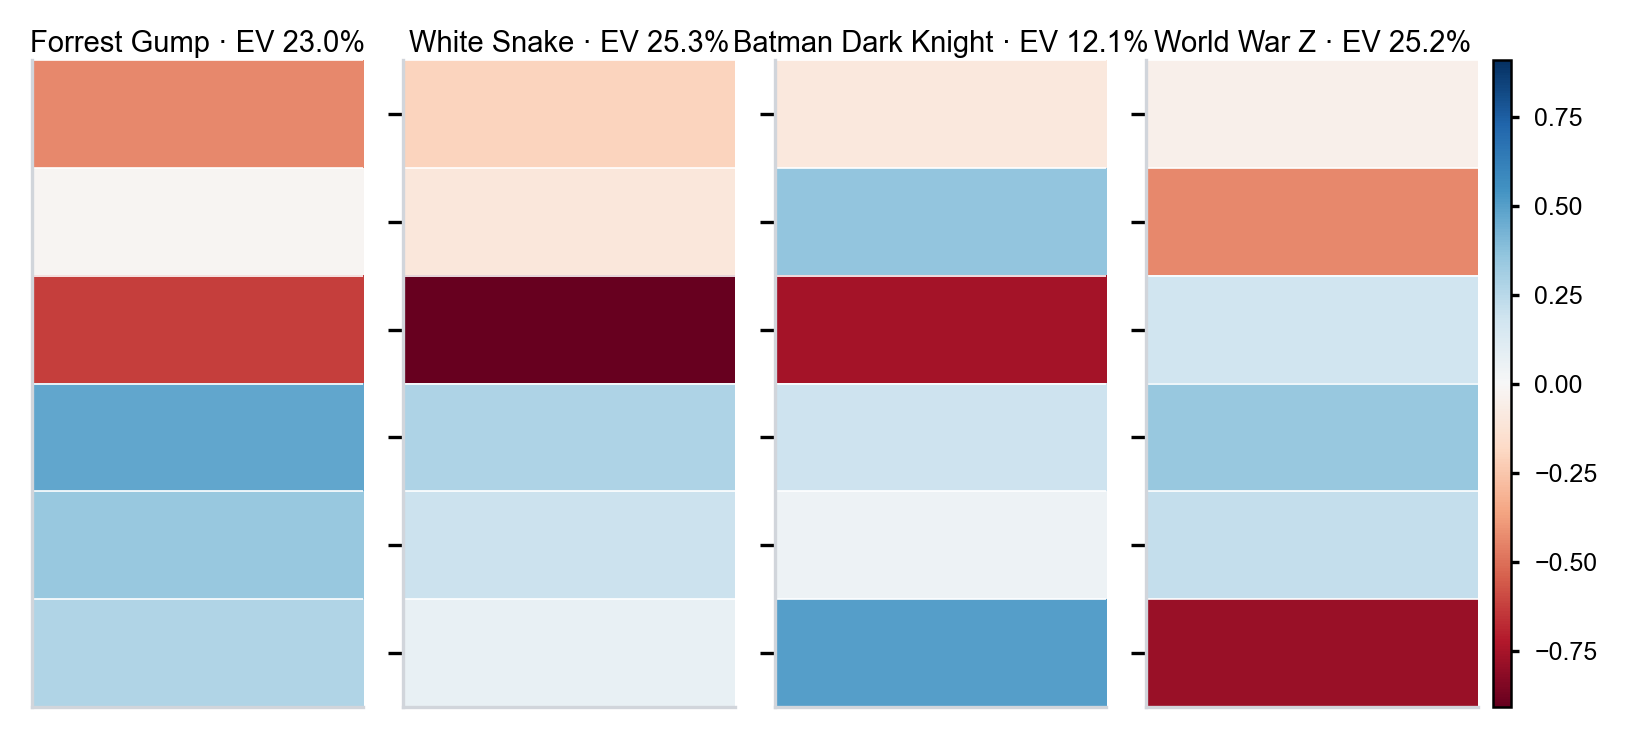

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

EMO_NAMES   = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
SPINE_COLOR = "#D1D5DB"
EDGE_COLOR  = "#2E3440"

pretty_name = {
    "forrest_gump": "Forrest Gump",
    "White_snake": "White Snake",
    "Batman_darknight": "Batman Dark Knight",
    "World_War_Z": "World War Z",
}

def plot_vertical_loading_columns(loadings_mat, films, evr,
                                  figsize=(4.6, 1.9), dpi=300, savepath=None):
    """
    loadings_mat: (4, 6)  行=电影，列=6种情绪
    films:        长度4，与行对应
    evr:          长度4，explained variance（0~1 或 0~100）
    """
    L = np.asarray(loadings_mat, float)
    evr = np.asarray(evr, float)
    evr_pct = evr*100 if np.nanmax(evr) <= 1.05 else evr

    vmax = float(np.nanmax(np.abs(L))) if L.size else 1.0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    fig, axes = plt.subplots(
        1, 4, figsize=figsize, dpi=dpi, sharey=True,
        gridspec_kw={"wspace": 0.12}  # 更紧凑
    )

    ims = []
    for ax, row, film, ev in zip(axes, L, films, evr_pct):
        A = row[:, np.newaxis]
        im = ax.imshow(A, cmap="RdBu", norm=norm, interpolation="nearest",
                       aspect="auto")
        ims.append(im)

        # 细白分隔线（更轻）
        ax.set_yticks(np.arange(len(EMO_NAMES)+1)-0.5, minor=True)
        ax.grid(which="minor", axis="y", color="white", linewidth=0.4)
        ax.tick_params(axis='y', which='minor', length=0)

        # x 轴隐藏
        ax.set_xticks([])

        # 仅最左侧显示情绪名，减小字号与间距
        ax.set_yticks(np.arange(len(EMO_NAMES)))
        if ax is axes[0]:
            ax.set_yticklabels(EMO_NAMES, fontsize=6)
            ax.tick_params(axis='y', pad=1, length=0)
        else:
            ax.set_yticklabels([])

        ax.set_ylim(len(EMO_NAMES)-0.5, -0.5)

        # 脊
        for side in ["top", "right"]:
            ax.spines[side].set_visible(False)
        ax.spines["left"].set_color(SPINE_COLOR)
        ax.spines["bottom"].set_color(SPINE_COLOR)

        # 标题精简为一行，缩小字号、减小顶端留白
        ax.set_title(f"{pretty_name.get(film, film)} · EV {ev:.1f}%",
                     fontsize=7, pad=2)

    # 右侧极窄 colorbar（无标签，仅刻度）
    cbar = fig.colorbar(ims[0], ax=axes, fraction=0.018, pad=0.01, aspect=35)
    cbar.ax.tick_params(labelsize=6, length=2)
    cbar.outline.set_linewidth(0.6)

    # 去掉全局 y 标签以节省空间
    # axes[0].set_ylabel("PCA complexity loadings", fontsize=8)

    plt.tight_layout(pad=0.3)
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", pad_inches=0.02)
    return fig, axes


# ===== 使用示例 =====
# films 顺序与 loadings_mat 行一致
films = ['forrest_gump', 'White_snake', 'Batman_darknight', 'World_War_Z']
# loadings_mat = np.random.randn(4, 6)   # 你的 4×6 数据
# evr = np.array([0.31, 0.28, 0.35, 0.26])  # 或百分数
fig, axes = plot_vertical_loading_columns(loadings_mat, films, evr,
                                          figsize=(6.4, 2.8), dpi=300,
                                          savepath="figures/pca_loading_columns.svg")
plt.show()


In [159]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def save_loading_strip_per_film(loadings_mat, films, outdir="figures",
                                cmap="RdBu", dpi=300, figsize=(1.0, 2.0),
                                ext="svg"):
    """
    为每个电影单独保存一张 6×1 竖条热图（无文字、无色标），统一色阶。
    loadings_mat: (4,6) 行=电影，列=6种情绪的PCA loading
    films:        长度4，与行对应；用于文件名
    """
    L = np.asarray(loadings_mat, float)
    os.makedirs(outdir, exist_ok=True)

    # 统一色阶：以全体四片的最大绝对值对称到 0
    vmax = float(np.nanmax(np.abs(L))) if L.size else 1.0
    if vmax == 0: vmax = 1.0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    for idx, (film, row) in enumerate(zip(films, L)):
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        A = row[:, np.newaxis]  # (6,1)
        ax.imshow(A, cmap=cmap, norm=norm, interpolation="nearest", aspect="auto")

        # 行分隔的细白线（非文字）
        ax.set_yticks(np.arange(A.shape[0]+1)-0.5, minor=True)
        ax.grid(which="minor", axis="y", color="white", linewidth=0.4)

        # 去除所有文本与刻度
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xticklabels([]); ax.set_yticklabels([])
        for side in ["top", "right", "left", "bottom"]:
            ax.spines[side].set_visible(False)

        # 上下顺序保持从上到下为 0..5
        ax.set_ylim(A.shape[0]-0.5, -0.5)

        plt.tight_layout(pad=0.02)
        fname = f"{idx:02d}_{film}_pca_loading_strip.{ext}"
        plt.savefig(os.path.join(outdir, fname), bbox_inches="tight", pad_inches=0.02)
        plt.close(fig)

# ===== 用法示例 =====
# films 顺序与矩阵行一致
films = ['forrest_gump', 'White_snake', 'Batman_darknight', 'World_War_Z']
# loadings_mat = np.random.randn(4, 6)   # 你的 4×6 数据
save_loading_strip_per_film(loadings_mat, films,
                            outdir="figures",
                            cmap="RdBu",      # 如需反转，用 "RdBu_r"
                            dpi=300,
                            figsize=(0.9, 1.9),
                            ext="svg")        # 也可选 "png"


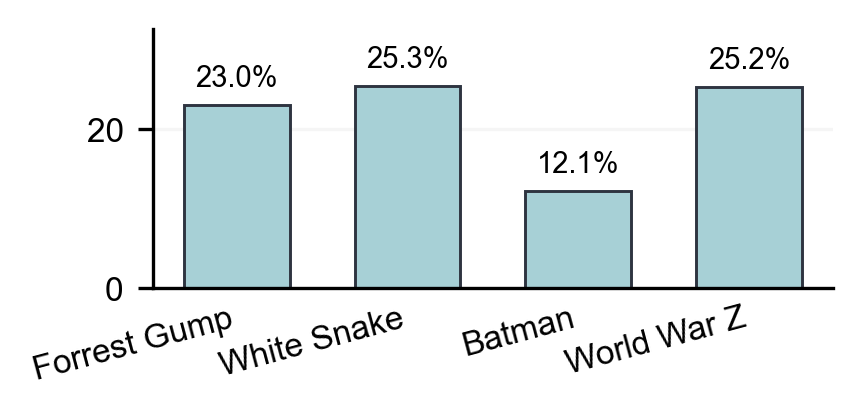

In [333]:
import numpy as np
import matplotlib.pyplot as plt

SPINE_COLOR = "#D1D5DB"
EDGE_COLOR  = "#2E3440"
BAR_COLOR   = "#A7D0D6"   # 柔和浅雾蓝（不突兀）
# 也可试试更偏绿的柔和色： "#AEC9B5"

pretty_name = {
    "forrest_gump": "Forrest Gump",
    "White_snake": "White Snake",
    "Batman_darknight": "Batman",
    "World_War_Z": "World War Z",
}

def plot_ev_bars_vertical_value(films, evr, figsize=(4.0, 2.4), dpi=300, savepath=None):
    """
    films: 长度4的电影 key 列表
    evr:   长度4的 explained variance；可为比例(0~1)或百分数(0~100)
    """
    # plt.rcParams['font.size']=10
    films = list(films)
    evr = np.asarray(evr, float)
    evr_pct = evr * 100.0 if np.nanmax(evr) <= 1.05 else evr

    labels = [pretty_name.get(k, k) for k in films]
    x = np.arange(len(films))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    bars = ax.bar(x, evr_pct, width=0.62, color=BAR_COLOR,
                  edgecolor=EDGE_COLOR, linewidth=0.7)

    ymax = float(np.nanmax(evr_pct)) if evr_pct.size else 100.0
    pad  = max(1.6, 0.01 * max(100.0, ymax))  # 竖排文字留白

    # 在柱子内部标注电影名；在柱顶竖排标注 EV 数值
    for xx, hh, name in zip(x, evr_pct, labels):
        # 内部名字：自适应颜色与位置
        # inside_color = "white" if hh >= 14 else EDGE_COLOR
        inside_y = hh * 0.55 if hh >= 10 else min(hh * 0.70 + 2.0, hh - 0.4) if hh > 2 else 1.0
        # ax.text(xx, inside_y, name, ha="center", va="center",
        #         fontsize=5,  fontweight="bold", clip_on=True, rotation=90, rotation_mode="anchor")

        ax.text(xx, hh + pad, f"{hh:.1f}%", ha="center", va="bottom",
                fontsize=7, clip_on=False)

    # 轴样式（极简）
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(labels, rotation=15, ha="right", fontsize=8)  
    ax.yaxis.grid(True, linestyle='-', alpha=0.12)
    ax.set_axisbelow(True)

    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    # ax.spines["left"].set_color(SPINE_COLOR)
    # ax.spines["bottom"].set_color(SPINE_COLOR)

    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', labelsize=8)

    ax.set_ylim(0, min(100.0, ymax * 1.22 + pad))  # 给竖排数值留足空间
    plt.tight_layout(pad=0.4)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    return fig, ax

# ===== 示例调用 =====
films = ['forrest_gump', 'White_snake', 'Batman_darknight', 'World_War_Z']
# evr = [0.31, 0.28, 0.35, 0.26]  # 或 [31.0, 28.0, 35.0, 26.0]
fig, ax = plot_ev_bars_vertical_value(films, evr,
    figsize=(2.8, 1.3), dpi=300, savepath="figures/ev_bar_soft_vertical.svg")
plt.show()


#### Example curves (Forrest Gump)

(4218, 6)


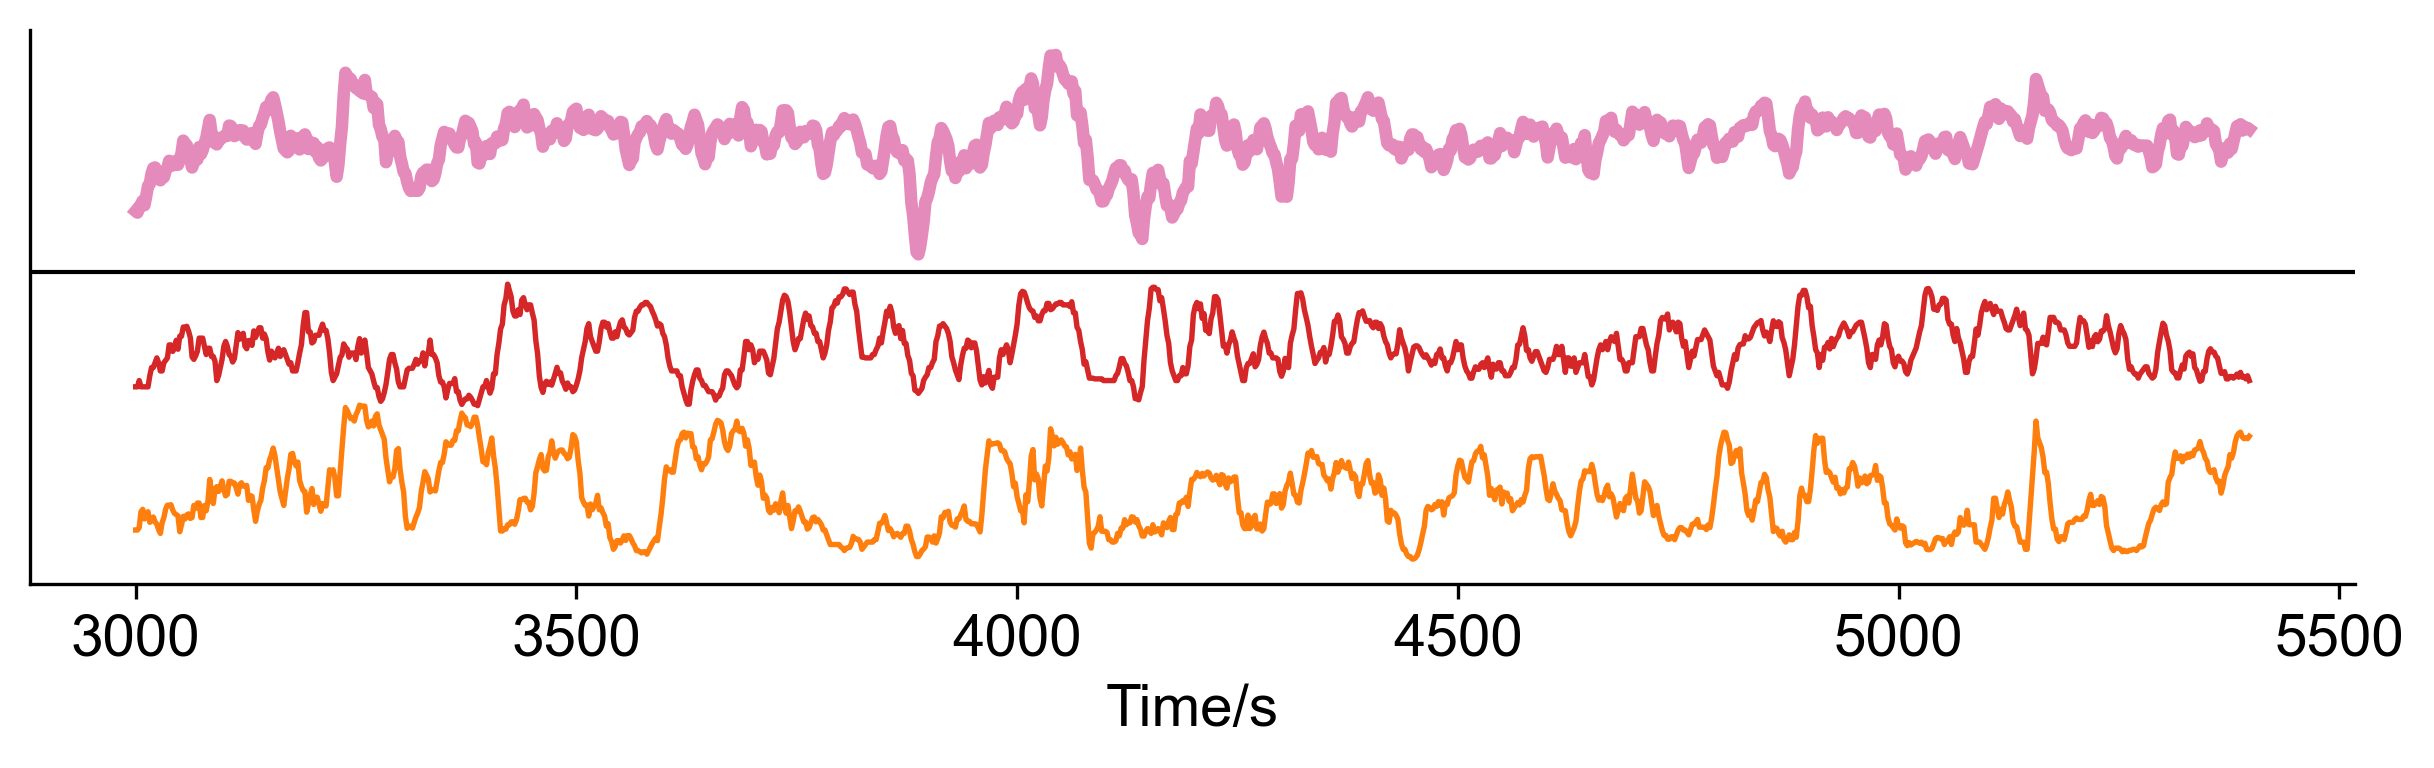

22


In [415]:
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

sel_range = np.arange(1500,2700)
loadings_mat = np.zeros((4,6))
evr = np.zeros(4)
plt.rcParams['font.size'] = 14
for count, key in enumerate(sel_keys[:1]):
    scores_now = scores_sel[key]
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(scores_now)
    print(X_pca.shape)
    fig, ax = plt.subplots(figsize=(10,2.4), dpi=300)
    plt.plot(sel_range*2, X_pca[sel_range,1]+18, color="#E58BBB", linewidth=3)
    plt.plot(sel_range*2, scores_now[sel_range,0]+5, color=EMO_COLORS[0], linewidth=1.3)
    plt.plot(sel_range*2, scores_now[sel_range,2], color=EMO_COLORS[2], linewidth=1.3)
    plt.axhline(12, color='k', linewidth=1)
    plt.yticks([])
    plt.xlabel('Time/s')
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    # ax.spines["left"].set_color(SPINE_COLOR)
    # ax.spines["bottom"].set_color(SPINE_COLOR)
    plt.savefig('figures/ha_sa_curves_fg.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(np.argmax(X_pca[2000:2050,1]))
    
    # plt.figure(figsize=(15,6))
    # for i in range(6):
    #     plt.plot(np.arange(0,X_pca.shape[0]*2,2), scores_now[:,i]+4*i, color=EMO_COLORS[i])
    # plt.show()

In [194]:
scores_now[2022,:]

array([5.68, 4.39, 5.15, 1.07, 0.83, 0.68])

In [191]:
X_pca[2019:2023,1]

array([2.98312058, 2.80631954, 2.70119653, 3.00624619])

In [195]:
# 2019
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Processed_danmu\movie_batch1\danmu_forrest_gump_downsample.pkl', 'rb') as f:
    danmu = pickle.load(f)
print(len(danmu['forrest_gump.csv']))

5756


In [197]:
time_points = np.array([np.mean([danmu['forrest_gump.csv_time_range'][i][0], danmu['forrest_gump.csv_time_range'][i][1]]) for i in range(5756)])
print(np.argmin(np.abs(time_points-2022*2)))
print(time_points[2829])

2829
4044.0


In [198]:
4044/60

67.4

In [199]:
print(danmu['forrest_gump.csv'][2829])

如果是去见你 我一定是跑着去的！
想哭
第一次看的时候，惊讶这池子原来不需要游泳就能过
最好的反战宣言
跌跌撞撞奔向你
名场面
史诗构图
名场面
这也太。。
呜呜呜呜呜呜呜呜呜
想要知道说了什么的，网上会有大量的信息告诉你
谢谢你一直守候着这份笨拙且执着的爱
老实人系列
原来这池子这么浅的啊
名画
双向的奔赴就会幸福吗
所以阿甘到底说了啥？
名场面合影
当年看到这里哭了
南北一拥


#### Example curves (World War Z)

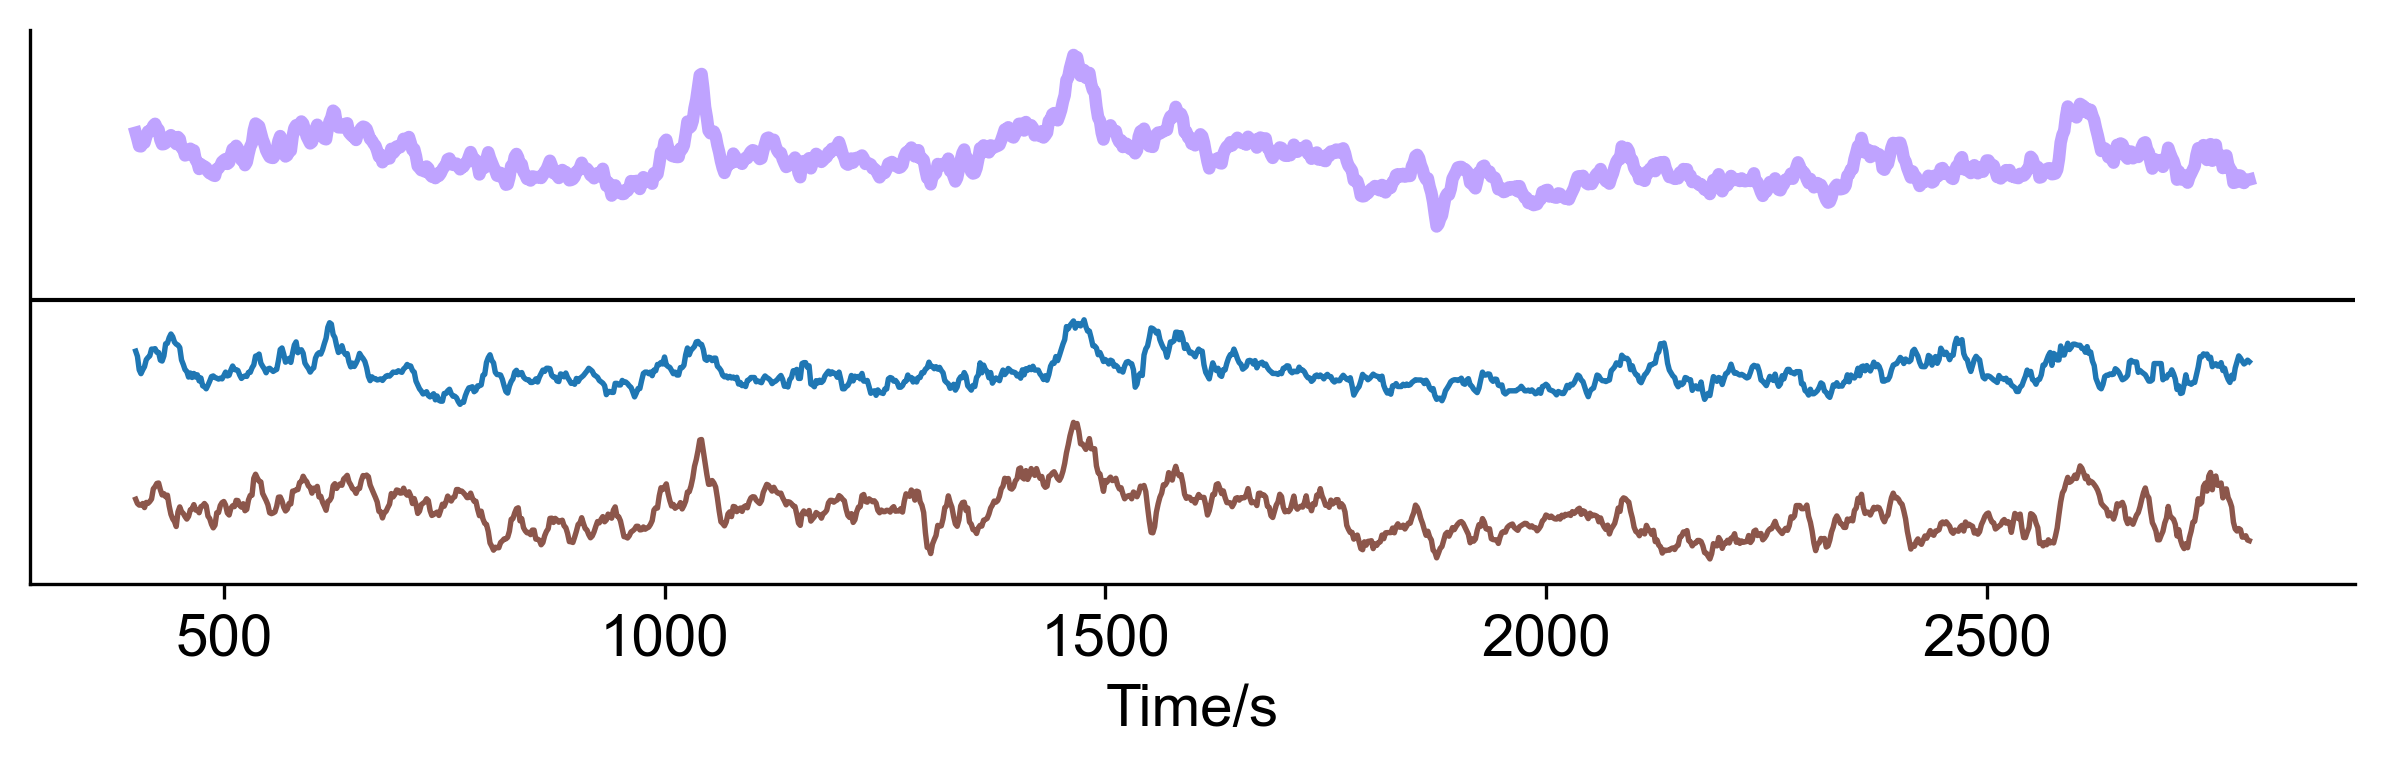

32


In [416]:
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']


loadings_mat = np.zeros((4,6))
evr = np.zeros(4)
plt.rcParams['font.size'] = 14
for count, key in enumerate(sel_keys[3:]):
    scores_now = scores_sel[key]
    sel_range = np.arange(200,1400)
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(scores_now)
    fig, ax = plt.subplots(figsize=(10,2.4), dpi=300)
    plt.plot(sel_range*2, X_pca[sel_range,1]+18, color="#BFA3FF", linewidth=3)
    plt.plot(sel_range*2, scores_now[sel_range,1]+5, color=EMO_COLORS[1], linewidth=1.3)
    plt.plot(sel_range*2, scores_now[sel_range,5], color=EMO_COLORS[5], linewidth=1.3)
    plt.axhline(12, color='k', linewidth=1)
    plt.yticks([])
    plt.xlabel('Time/s')
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    # ax.spines["left"].set_color(SPINE_COLOR)
    # ax.spines["bottom"].set_color(SPINE_COLOR)
    plt.savefig('figures/ha_sa_curves_wwz.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(np.argmax(X_pca[700:800,1]))

In [236]:
print(scores_now[732,:])
print(X_pca[728:739])

[0.85 6.05 0.   1.8  0.95 6.55]
[[ 0.66189273  3.73574949 -0.6908031  -0.42444386  0.90593834 -0.09802682]
 [ 1.06377708  3.84893849 -0.70580656 -0.58878552  0.68055807 -0.04657133]
 [ 1.40736376  4.26290164 -1.1720233  -0.79949478  0.86648859 -0.08847716]
 [ 1.70329559  4.56409911 -1.6029171  -0.97523289  1.03370678 -0.1988817 ]
 [ 1.90179453  4.84922894 -1.7749299  -1.16567638  1.03692051 -0.44572516]
 [ 1.91885223  4.47590766 -1.75413398 -1.16878173  0.82387511 -0.28663463]
 [ 1.86619404  4.75291774 -1.70587698 -1.08510358  0.94465163 -0.01446778]
 [ 1.65365943  4.37269507 -1.10280157 -1.13917657  0.77787548 -0.04313185]
 [ 1.2065238   3.9262816  -0.84051283 -1.06225738  0.76077037  0.0141413 ]
 [ 1.06819159  4.03866992 -0.78889445 -0.98111073  0.83426068  0.22881083]
 [ 0.66099411  4.17964874 -0.71621454 -0.86080373  0.95970679  0.20595662]]


In [232]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Processed_danmu\movie_batch1\danmu_World_War_Z_downsample.pkl', 'rb') as f:
    danmu = pickle.load(f)
print(danmu.keys())
print(len(danmu['World_War_Z.csv']))

time_points = np.array([np.mean([danmu['World_War_Z.csv_time_range'][i][0], danmu['World_War_Z.csv_time_range'][i][1]]) for i in range(len(danmu['World_War_Z.csv']))])
print(np.argmin(np.abs(time_points-732*2)))
print(time_points[1381])

dict_keys(['World_War_Z.csv', 'World_War_Z.csv_time_range'])
6326
1381
1464.0


In [233]:
1464/60

24.4

In [237]:
print(danmu['World_War_Z.csv'][1381])

啊啊啊啊啊啊啊啊啊啊啊啊
操
卧槽吓我一跳
感谢高能君 木有被吓到
艾玛吓死我
谢谢高能，让我及时关掉了音量
卧槽，卧槽，被吓一激灵
握草！！！！！！
草
吓死啦
感谢高能君
吓死人
我TM的
我为什么这个时候按快进T_T
草
感谢高能君
握草
wdnmd
来了/
跪谢高能君


### Statistics according to movie genres

In [246]:
scores_dict.keys()

dict_keys(['Batman_darknight', 'Be_somebody', 'forrest_gump', 'Gashapon', 'Godzilla', 'Green_book', 'Harry_potter', 'Heidi', 'Kong_fu', 'let_bullet_fly_reorder', 'Luo_xiao_hei', 'The_bad_guys', 'The_Shawshank_Redemption', 'The_Wandering_Earth_II', 'Weathering_With_You', 'White_snake', 'World_War_Z', 'Yang_jian', 'BV1134y1g7Vq', 'BV11x4y117NY', 'BV147411y71D', 'BV14b411c72z', 'BV14E411C7Lf', 'BV14T4y1u7ST', 'BV163411i7Un', 'BV164411k73g', 'BV16e4y1P7sa', 'BV17f4y1n7et', 'BV17h411D7aX', 'BV17W411r78v', 'BV17W411Z7Lh', 'BV18E411e7By', 'BV191421B7B9', 'BV19x41127Nd', 'BV1BJ411S7Ch', 'BV1bL411578p', 'BV1bz4y1a7QZ', 'BV1cW411a7ed', 'BV1Ds411V7cP', 'BV1dU4y1g73N', 'BV1Dx411u7jw', 'BV1e4411k74a', 'BV1E4411U7Qu', 'BV1ED4y1j7Jn', 'BV1Ee4y1B74h', 'BV1eJ411B7to', 'BV1Fb411F7fk', 'BV1Fb411z7Zy', 'BV1ht4y1D7tG', 'BV1j4411X7CV', 'BV1j44y1y7YQ', 'BV1kJ411j7pH', 'BV1kK4y1b7dH', 'BV1Kx411p7hz', 'BV1ky4y167Tg', 'BV1Lp411R7Fx', 'BV1LP4y1H7TJ', 'BV1M7411J7kP', 'BV1ms411U75B', 'BV1mw4m1e7BD', 'BV1na4y1Y7rR'

In [255]:
# Movie names
import pandas as pd
import pickle
with open(r'Y:\xinke\Danmu\DyEmo-film\Emotion_scores\scores_allMovies_resample.pkl', 'rb') as f:
    scores_dict = pickle.load(f)
keys = list(scores_dict.keys())
file_path = r'Y:\xinke\Danmu\DyEmo-film\movie_info.CSV'  # 替换为你的文件路径

# 读取 Excel 文件
df = pd.read_csv(file_path)
eng_names = df['EnglishName'].astype(str).tolist()  # 确保转换为字符串类型
eng_names = [eng_names[i][1:] for i in range(len(eng_names))]
bvids = df['BVID'].astype(str).tolist()  # 确保转换为字符串类型
chi_names = df['Name'].astype(str).tolist() 

import copy
movie_names = copy.deepcopy(keys)
for i in range(len(keys)):
    for j in range(len(bvids)):
        if bvids[j] == keys[i]:
            movie_names[i] = chi_names[j]
# movie_names = [movie_names[i] for i in range(len(movie_names)) if i not in [50,99,102]]
# print(movie_names)

movie_names_eng = [
    "Batman Dark Knight",
    "Be Somebody",
    "Forrest Gump",
    "Big World Gashapon",
    "Godzilla",
    "Green Book",
    "Harry Potter and the Goblet of Fire",
    "Heidi",
    "Kung Fu",
    "Let the Bullets Fly",
    "The Legend of Luo Xiaohei",
    "The Bad Guys",
    "The Shawshank Redemption",
    "The Wandering Earth II",
    "Weathering With You",
    "White Snake",
    "World War Z",
    "Yang Jian",
    "Suzume",  # 铃芽之旅
    "Johnny Keep Walking!",  # 年会不能停!
    "The Lord of the Rings: The Fellowship of the Ring",  # 指环王1
    "The SpongeBob SquarePants Movie",  # 海绵宝宝历险记
    "Our Fathers",  # 我们的父辈
    "Detective Conan: The Phantom of Baker Street",  # 名侦探柯南
    "Love Letter",  # 情书
    "Harry Potter and the Order of the Phoenix",
    "Detective Conan: The Bride of Halloween",
    "White Snake 2: The Tribulation of Green Snake",
    "New Gods: Nezha Reborn",
    "The Truman Show",  # 楚门的世界
    "Transformers",
    "Flipped",  # 怦然心动
    "The Pig, the Snake and the Pigeon",  # 周处除三害
    "Date A Live Movie: Mayuri Judgment",
    "Rascal Does Not Dream of a Dreaming Girl",
    "Violet Evergarden: The Movie",
    "Journey to the West",  # 宇宙探索编辑部
    "Sword Art Online: Ordinal Scale",  # 刀剑神域
    "Overlord: The Dark Hero",
    "Rurouni Kenshin",  # 浪客剑心
    "A Silent Voice",  # 声之形
    "Harry Potter and the Half-Blood Prince",
    "Harry Potter and the Chamber of Secrets",
    "Still Miss You",  # 还是觉得你最好
    "Ready Player One",  # 头号玩家
    "Edge of Tomorrow",  # 明日边缘
    "Transformers: Revenge of the Fallen",
    "Fate/stay night: Heaven's Feel I. presage flower",
    "Fantastic Beasts and Where to Find Them",
    "Harry Potter and the Sorcerer's Stone",
    "Promare",  # 普罗米亚
    "Fireworks",  # 烟花
    "Goodbye Mr. Loser",  # 夏洛特烦恼
    "Tamako Love Story",  # 玉子爱情故事
    "Leap",  # 夺冠
    "A Little Thing Called Love",  # 初恋这件小事
    "The Legend of Sealed Book",  # 天书奇谭
    "The SpongeBob Movie: Sponge Out of Water",  # 海绵宝宝水兵陆战队
    "The Garden of Words",  # 言叶之庭
    "Kowloon Walled City",  # 九龙城寨
    "The Silence of the Lambs",
    "Inception",  # 盗梦空间
    "Interstellar",
    "Deep Sea",  # 深海
    "Jiang Ziya",  # 姜子牙
    "Harry Potter and the Deathly Hallows Part 2",
    "CJ7",  # 长江七号
    "Lost on Journey",  # 人在囧途
    "Only Fools Rush In",  # 四海
    "Five Hundred Miles",  # 交换人生
    "The Godfather",
    "Harry Potter and the Prisoner of Azkaban",
    "Minions",  # 小黄人大眼萌
    "Violet Evergarden: Eternity and the Auto Memories Doll",
    "One Second",  # 一秒钟
    "Sword Art Online Progressive: Aria of a Starless Night",
    "Catch Me If You Can",  # 猫鼠游戏
    "Wolf Warrior",  # 战狼
    "Brotherhood of Blades",  # 绣春刀
    "Hidden Blade",  # 无名
    "Endless Journey",  # 三大队
    "Pegasus 2",  # 飞驰人生2
    "Evangelion: 2.22 You Can (Not) Advance",
    "Evangelion: 3.33 You Can (Not) Redo",
    "Evangelion: 1.11 You Are (Not) Alone",
    "Evangelion: Death and Rebirth",
    "Crazy Racer",  # 疯狂的赛车
    "My Little Pony Equestria Girls: Friendship Games",  # 彩虹小马
    "My Own Swordsman",  # 武林外传
    "Words Bubble Up Like Soda Pop",  # 言语如苏打般涌现
    "No Time to Die",  # 007
    "Overlord: The Undead King",
    "5 Centimeters Per Second",  # 秒速5厘米
    "Win the Kids",  # 抓娃娃
    "The Founding of a Republic",  # 建国大业
    "Ip Man",  # 叶问
    "The King's Avatar: For the Glory",  # 全职高手
    "Shin Ultraman",  # 新·奥特曼
    "Pleasant Goat and Big Big Wolf: Dunk for Future",  # 喜羊羊
    "One Piece Film: Red",  # 航海王
    "Johnny English",  # 憨豆特工
    "Pacific Rim"  # 环太平洋
]

In [267]:
df = pd.read_csv(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\movie_genre_onehot.csv')
action = np.array(df['Action'].tolist())[:-1]
print(np.sum(action), action)
print([movie_names[i] for i in range(102) if action[i]==1])
keys_action = [keys[i] for i in range(102) if action[i]==1]

romance = np.array(df['Romance'].tolist())[:-1]
print(np.sum(romance), romance)
print([movie_names[i] for i in range(102) if romance[i]==1])
keys_romance = [keys[i] for i in range(102) if romance[i]==1]

comedy = np.array(df['Comedy'].tolist())[:-1]
print(np.sum(comedy), comedy)
print([movie_names[i] for i in range(102) if comedy[i]==1])
keys_comedy = [keys[i] for i in range(102) if comedy[i]==1]

keys_noncomedy = [keys[i] for i in range(102) if comedy[i]==0]

30 [1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1]
['Batman_darknight', 'Godzilla', 'Kong_fu', 'let_bullet_fly_reorder', 'Luo_xiao_hei', 'World_War_Z', 'Yang_jian', '指环王1：护戒使者', '名侦探柯南：万圣节的新娘', '新神榜：哪吒重生', '变形金刚', '周处除三害', '浪客剑心', '头号玩家', '明日边缘', '变形金刚2', '普罗米亚', '九龙城寨之围城', '四海', '刀剑神域进击篇：无星之夜', '战狼', '绣春刀', '疯狂的赛车', '武林外传', '007：无暇赴死', '叶问', '全职高手之巅峰荣耀', '航海王：红发歌姬', '憨豆特工', '环太平洋']
14 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['forrest_gump', 'Gashapon', 'Weathering_With_You', 'White_snake', '我们的父辈', '情书', '怦然心动', '紫罗兰永恒花园剧场版', '声之形', '还是觉得你最好', '夏洛特烦恼', '玉子爱情故事', '初恋这件小事', '四海']
26 [0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0

In [276]:
# Co-occurrence in different types of movies
i = 0
j = 2
thr = 3.5
coocc_action = np.zeros(len(keys_action))
for m in range(len(keys_action)):
    scores_now = scores_dict[keys_action[m]]
    coocc_action[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
print(np.mean(coocc_action), np.std(coocc_action))

coocc_romance = np.zeros(len(keys_romance))
for m in range(len(keys_romance)):
    scores_now = scores_dict[keys_romance[m]]
    coocc_romance[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
print(np.mean(coocc_romance), np.std(coocc_romance))

print(stats.ttest_ind(coocc_action, coocc_romance))

i = 1
j = 5
thr = 3.5
coocc_action = np.zeros(len(keys_action))
for m in range(len(keys_action)):
    scores_now = scores_dict[keys_action[m]]
    coocc_action[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
print(np.mean(coocc_action), np.std(coocc_action))

coocc_romance = np.zeros(len(keys_romance))
for m in range(len(keys_romance)):
    scores_now = scores_dict[keys_romance[m]]
    coocc_romance[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
print(np.mean(coocc_romance), np.std(coocc_romance))

print(stats.ttest_ind(coocc_action, coocc_romance))

i = 1
j = 3
thr = 3.5
coocc_action = np.zeros(len(keys_action))
for m in range(len(keys_action)):
    scores_now = scores_dict[keys_action[m]]
    coocc_action[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
print(np.mean(coocc_action), np.std(coocc_action))

coocc_romance = np.zeros(len(keys_romance))
for m in range(len(keys_romance)):
    scores_now = scores_dict[keys_romance[m]]
    coocc_romance[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
print(np.mean(coocc_romance), np.std(coocc_romance))

print(stats.ttest_ind(coocc_action, coocc_romance))


# i = 0
# j = 1
# thr = 3.5
# coocc_action = np.zeros(len(keys_action))
# for m in range(len(keys_action)):
#     scores_now = scores_dict[keys_action[m]]
#     coocc_action[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
# print(np.mean(coocc_action), np.std(coocc_action))

# coocc_romance = np.zeros(len(keys_romance))
# for m in range(len(keys_romance)):
#     scores_now = scores_dict[keys_romance[m]]
#     coocc_romance[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
# print(np.mean(coocc_romance), np.std(coocc_romance))

# print(stats.ttest_ind(coocc_action, coocc_romance))


# i = 0
# j = 1
# thr = 3.5
# coocc_comedy = np.zeros(len(keys_comedy))
# for m in range(len(keys_comedy)):
#     scores_now = scores_dict[keys_comedy[m]]
#     coocc_comedy[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
# print(np.mean(coocc_comedy), np.std(coocc_comedy))

# coocc_noncomedy = np.zeros(len(keys_noncomedy))
# for m in range(len(keys_noncomedy)):
#     scores_now = scores_dict[keys_noncomedy[m]]
#     coocc_noncomedy[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
# print(np.mean(coocc_noncomedy), np.std(coocc_noncomedy))

# print(stats.ttest_ind(coocc_comedy, coocc_noncomedy))

0.027815014597053815 0.021951817546202228
0.09562507903249676 0.0557592765939088
TtestResult(statistic=-5.638501182471176, pvalue=1.313138433613497e-06, df=42.0)
0.015483177142504303 0.022713652252126373
0.010515765534956114 0.011954985514323706
TtestResult(statistic=0.7523236330112971, pvalue=0.45605234247675364, df=42.0)
0.08650516988081063 0.052249161883333374
0.03876046699892135 0.0482123763814058
TtestResult(statistic=2.825899623580673, pvalue=0.007187163750839877, df=42.0)


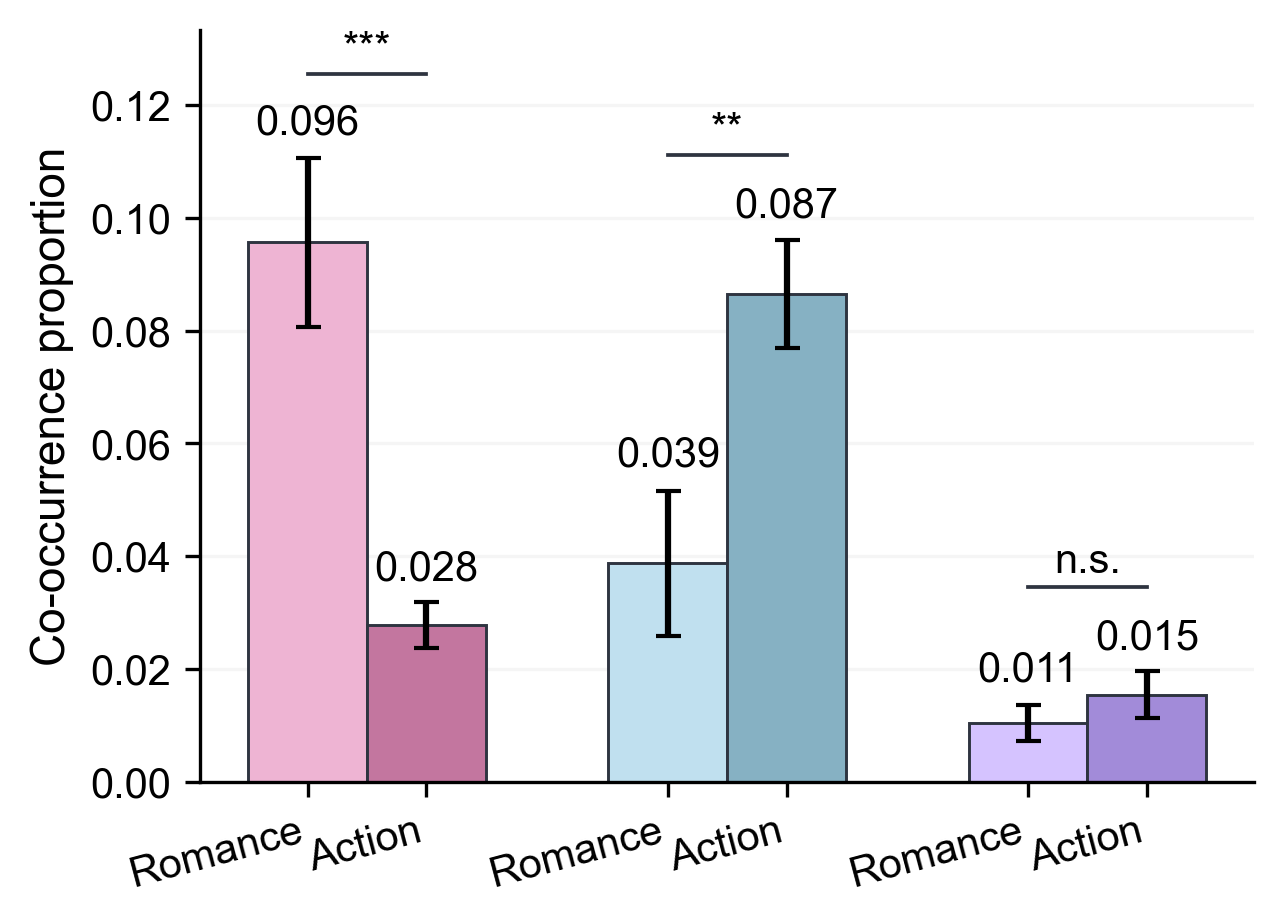

In [374]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from scipy import stats

# 依赖：scores_dict, keys_romance, keys_action, pair_coocc_prop 已在环境中
PAIR_COLORS = {
    "HS": "#E58BBB",   # Happiness + Sadness
    "SF": "#BFA3FF",   # Surprise + Fear
    "SA": "#9ED0E6",   # Surprise + Anger（新增）
}
SPINE_COLOR = "#D1D5DB"
EDGE_COLOR  = "#2E3440"

def lighten(hex_color, t=0.35):
    r,g,b = to_rgb(hex_color)
    return (r + (1-r)*t, g + (1-g)*t, b + (1-b)*t)
def darken(hex_color, t=0.15):
    r,g,b = to_rgb(hex_color)
    return (r*(1-t), g*(1-t), b*(1-t))

def _samples(i, j, thr=3.5):
    rom = np.array([pair_coocc_prop(scores_dict[k], i, j, thr, segments=None) for k in keys_romance])
    act = np.array([pair_coocc_prop(scores_dict[k], i, j, thr, segments=None) for k in keys_action])
    return rom, act

def _p_to_stars(p):
    return "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "n.s."
    # 若只要 "**"： return "**" if p < 1e-2 else ""

def plot_grouped_with_sig(thr=3.5, figsize=(6.0, 3.0), dpi=300, savepath=None):
    groups = [("HS", 0, 2), ("SA", 1, 3), ("SF", 1, 5)]
    pair_text = {"HS":"HA + SA", "SF":"SU + FE", "SA":"SU + AN"}

    # 取样、本组均值与SE、p值
    means_rom, ses_rom, means_act, ses_act, pvals = [], [], [], [], []
    rom_list, act_list = [], []
    for tag, i, j in groups:
        rom, act = _samples(i, j, thr)
        rom_list.append(rom); act_list.append(act)
        means_rom.append(rom.mean()); ses_rom.append(rom.std(ddof=0)/np.sqrt(len(rom)))
        means_act.append(act.mean()); ses_act.append(act.std(ddof=0)/np.sqrt(len(act)))
        pvals.append(stats.ttest_ind(rom, act, equal_var=False).pvalue)  # Welch t-test

    G = len(groups)
    group_centers = np.arange(G) * 0.85
    w = 0.28
    offset = 0.28
    x_rom = group_centers - offset/2
    x_act = group_centers + offset/2

    rom_colors = [lighten(PAIR_COLORS[tag]) for tag,_,_ in groups]
    act_colors = [darken(PAIR_COLORS[tag])  for tag,_,_ in groups]

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    bars_rom = ax.bar(x_rom, means_rom, yerr=ses_rom, width=w,
                      color=rom_colors, edgecolor=EDGE_COLOR, linewidth=0.7,
                      capsize=3)
    bars_act = ax.bar(x_act, means_act, yerr=ses_act, width=w,
                      color=act_colors, edgecolor=EDGE_COLOR, linewidth=0.7,
                      capsize=3)

    # 数值标注：写在 errorbar 顶端之上
    def annotate_at_errtop(xs, means, ses):
        pad = max(0.002, 0.03 * max(means + ses))
        for x, m, se in zip(xs, means, ses):
            top = m + (se if np.isfinite(se) else 0.0)
            ax.text(x, top + pad, f"{m:.3f}", ha="center", va="bottom", fontsize=10)
    annotate_at_errtop(x_rom, means_rom, ses_rom)
    annotate_at_errtop(x_act, means_act, ses_act)

    # 组标签（HA+SA / SU+FE / SU+AN）
    # for xc, (tag, _, _) in zip(group_centers, groups):
    #     idx = [g[0] for g in groups].index(tag)
    #     top_high = max(means_rom[idx] + ses_rom[idx], means_act[idx] + ses_act[idx])
    #     ax.text(xc, 0.125, pair_text[tag],
    #             ha="center", va="bottom", fontsize=9, fontweight="bold")

    # 显著性括号与星号（组内两柱之间）
    def add_sig_bracket(x1, x2, y, text, h, text_pad):
        # 小括号
        ax.plot([x1, x2], [y, y], lw=0.9, color=EDGE_COLOR)
        ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=10)

    T = max(
        [m+s for m,s in zip(means_rom, ses_rom)] +
        [m+s for m,s in zip(means_act, ses_act)]
    ) if groups else 0.2
    h = max(0.001, 0.01*T)       # 括号高度
    # tpad = max(0.001, 0.0015*T)   # 星号与括号的距离
    tpad = 0.0005
    for g_idx in range(G):
        y_base = max(means_rom[g_idx] + ses_rom[g_idx], means_act[g_idx] + ses_act[g_idx])
        add_sig_bracket(x_rom[g_idx], x_act[g_idx], y_base + 0.015, _p_to_stars(pvals[g_idx]), h, tpad)

    # 横轴：每组两个tick——Romance / Action
    xticks = np.ravel(np.column_stack([x_rom, x_act])).tolist()
    ax.set_xticks(xticks)
    ax.set_xticklabels((["Romance", "Action"] * G), fontsize=10, rotation=15, ha="right")

    # 轴样式
    ax.set_ylabel("Co-occurrence proportion", fontsize=11)
    ax.yaxis.grid(True, linestyle="-", alpha=0.12)
    ax.set_axisbelow(True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    # ax.spines["left"].set_color(SPINE_COLOR)
    # ax.spines["bottom"].set_color(SPINE_COLOR)
    ax.tick_params(axis='y', labelsize=10)

    # y 上限：覆盖所有标注
    ymax_components = []
    for g_idx in range(G):
        top = max(means_rom[g_idx]+ses_rom[g_idx], means_act[g_idx]+ses_act[g_idx])
        ymax_components.append(top + 0.01*T + h + tpad + 0.01)  # 括号+星号+留白
    ax.set_ylim(0, max(ymax_components)+0.01)

    # 按要求不要图例
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    return fig, ax

# 使用示例

fig, ax = plot_grouped_with_sig(thr=3.5, figsize=(4.5, 3.3), dpi=300,
                                savepath="figures/coocc_romance_vs_action_groups_sig.svg")
plt.show()


In [272]:
thr = 3.5

for pair in [[0,1], [1,3], [0,2], [1,2], [0,3], [3,4], [2,3], [1,5], [1,4], [0,5]]:
    i = pair[0]
    j = pair[1]
    print(emos[pair[0]], emos[pair[1]])
    coocc_action = np.zeros(len(keys_action))
    for m in range(len(keys_action)):
        scores_now = scores_dict[keys_action[m]]
        coocc_action[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
    print(np.mean(coocc_action), np.std(coocc_action))

    coocc_romance = np.zeros(len(keys_romance))
    for m in range(len(keys_romance)):
        scores_now = scores_dict[keys_romance[m]]
        coocc_romance[m] = pair_coocc_prop(scores_now, i, j, thr, segments=None)
    print(np.mean(coocc_romance), np.std(coocc_romance))

    print(stats.ttest_ind(coocc_action, coocc_romance))

Happiness Surprise
0.5426209008617484 0.13070115608958802
0.48444934908635895 0.16231770887614363
TtestResult(statistic=1.240684316498771, pvalue=0.2216083191088218, df=42.0)
Surprise Anger
0.08650516988081063 0.052249161883333374
0.03876046699892135 0.0482123763814058
TtestResult(statistic=2.825899623580673, pvalue=0.007187163750839877, df=42.0)
Happiness Sadness
0.027815014597053815 0.021951817546202228
0.09562507903249676 0.0557592765939088
TtestResult(statistic=-5.638501182471176, pvalue=1.313138433613497e-06, df=42.0)
Surprise Sadness
0.030839560558481565 0.02251465331693621
0.07047480406471689 0.04300799594093485
TtestResult(statistic=-3.9144266891754333, pvalue=0.0003263755802995099, df=42.0)
Happiness Anger
0.0634970492128609 0.03920263246082995
0.03623146714752246 0.043710773663823976
TtestResult(statistic=2.0226014831307313, pvalue=0.04951196103850507, df=42.0)
Anger Disgust
0.020922785727273508 0.025618995309513854
0.03574311711597248 0.05364287135917302
TtestResult(statisti

In [275]:
intensity_mean_action = np.zeros((len(keys_action),6))
for m in range(len(keys_action)):
    scores_now = scores_dict[keys_action[m]]
    intensity_mean_action[m,:] = np.mean(scores_now, axis=0)
    
intensity_mean_romance = np.zeros((len(keys_romance),6))
for m in range(len(keys_romance)):
    scores_now = scores_dict[keys_romance[m]]
    intensity_mean_romance[m,:] = np.mean(scores_now, axis=0)

print('action:', np.mean(intensity_mean_action, axis=0))
print('romance', np.mean(intensity_mean_romance, axis=0))

for i in range(6):
    print(stats.ttest_ind(intensity_mean_action[:,i], intensity_mean_romance[:,i]))

action: [4.25101671 3.78760291 1.39076763 2.31669531 1.58345477 1.16741543]
romance [4.53633418 3.54156338 2.01997369 1.90953968 1.45543441 0.93780516]
TtestResult(statistic=-1.6984623427667913, pvalue=0.09681827908644566, df=42.0)
TtestResult(statistic=2.826820922099077, pvalue=0.007169867849441151, df=42.0)
TtestResult(statistic=-4.893916519232125, pvalue=1.5012019570323021e-05, df=42.0)
TtestResult(statistic=2.7679736490870077, pvalue=0.008355831468815257, df=42.0)
TtestResult(statistic=1.2622945349902752, pvalue=0.21380722335339608, df=42.0)
TtestResult(statistic=2.0140620140854715, pvalue=0.05043754442421754, df=42.0)
